# Imports

In [1]:
import tensorflow_addons as tfa
from utils import *
import tensorflow as tf
from tensorflow import keras
import pickle
from datetime import datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import keras_tuner
import warnings
import calendar
import collections.abc
collections.Iterable = collections.abc.Iterable
warnings.filterwarnings("ignore")


2023-04-30 02:53:32.907610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 02:54:13.872046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-30 02:54:13.872172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-30 02:54:13.872180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
print(tf.config.list_physical_devices('GPU'))


In [ ]:
%load_ext tensorboard


# Experiments

## Deeper Model

In [2]:
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))


(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [3]:
def model1(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.LSTM(50),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 24 Complete [00h 00m 23s]
val_loss: 8.219620704650879

Best val_loss So Far: 4.230430603027344
Total elapsed time: 00h 08m 46s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 1s 6ms/step


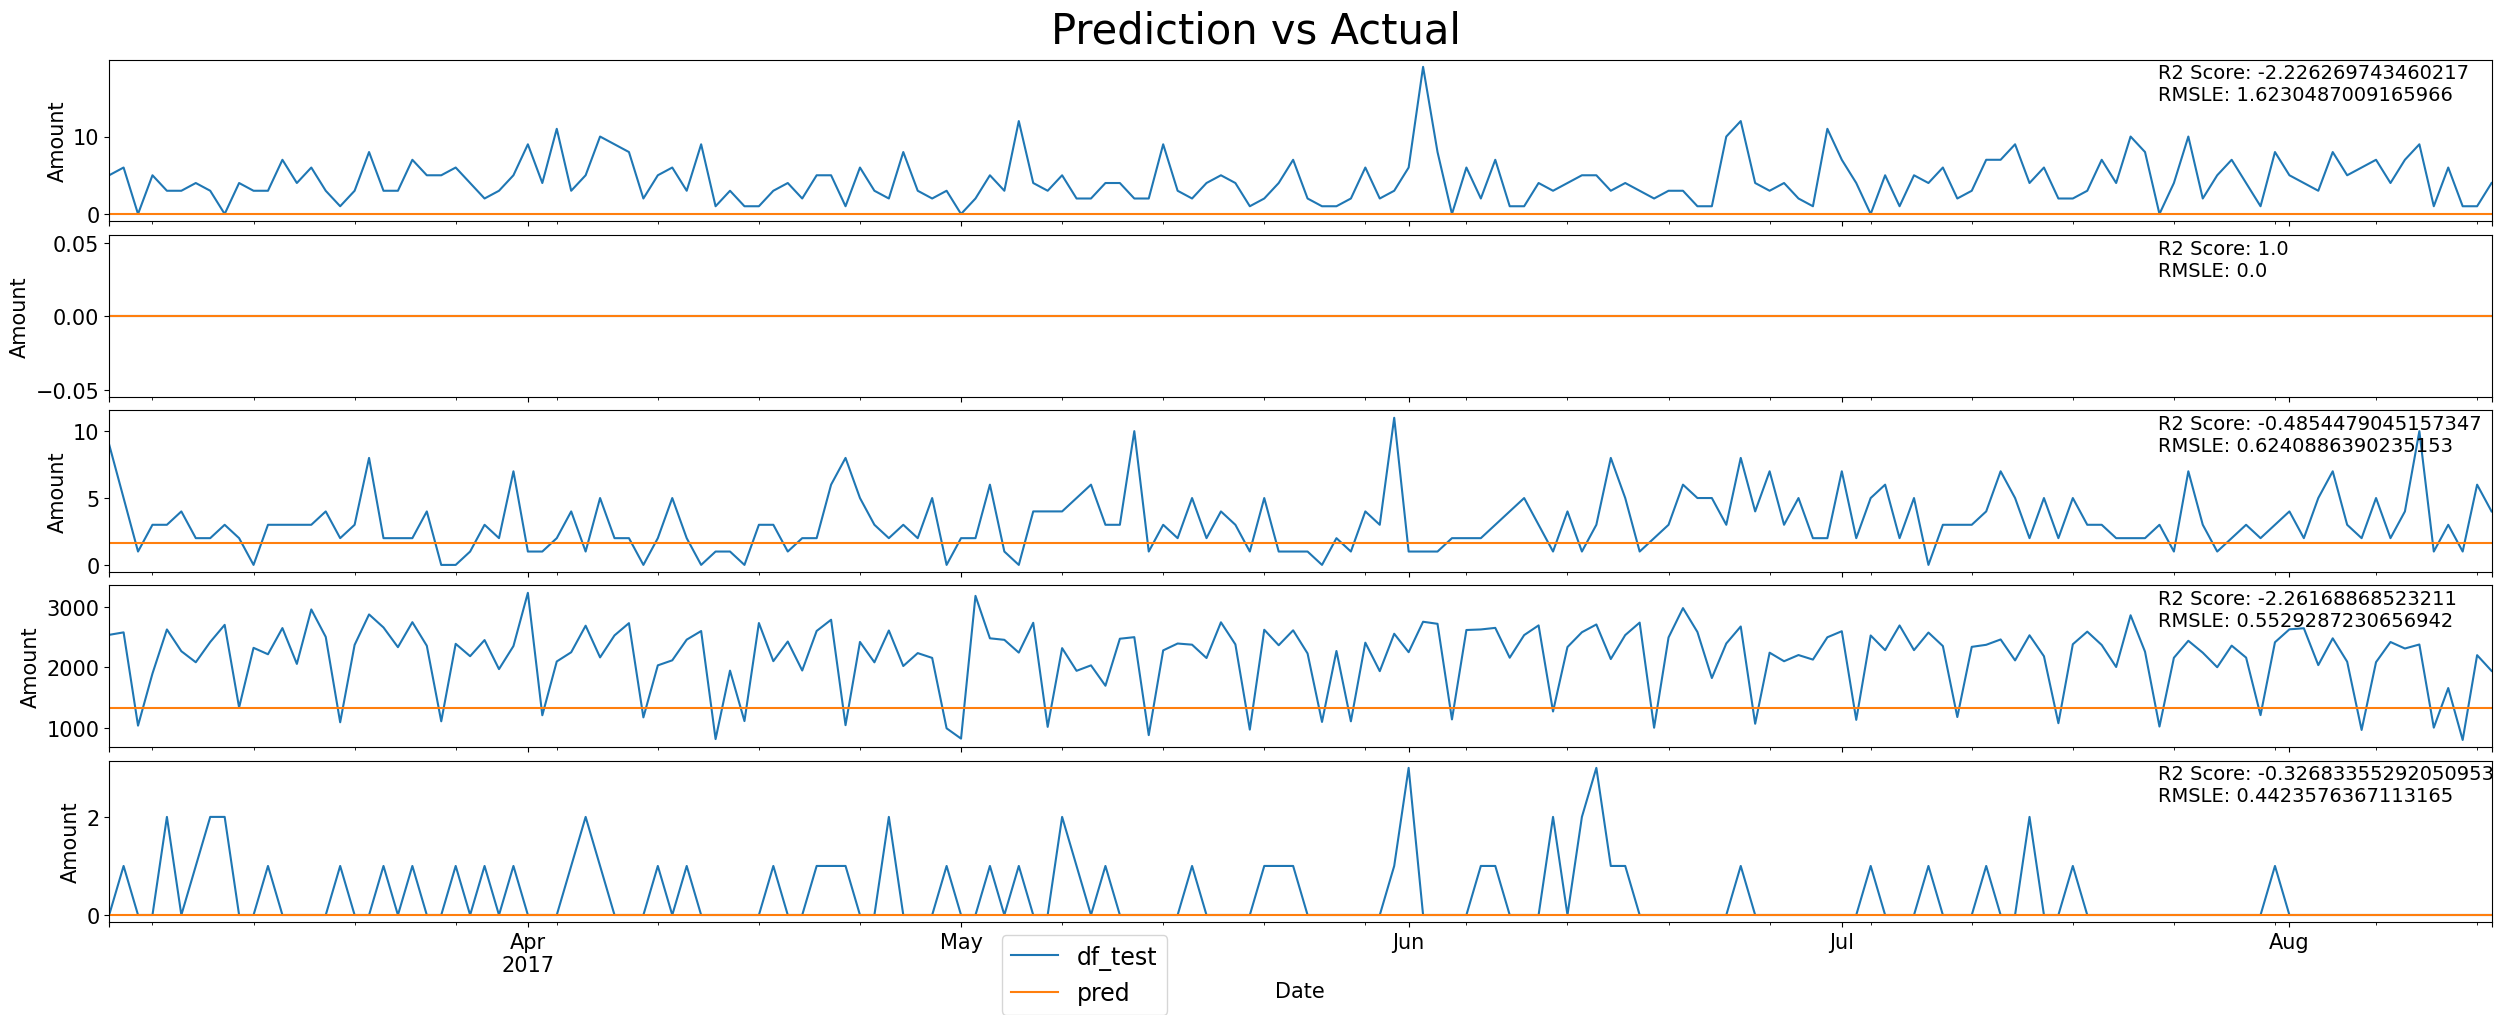

R2 Score                      -2.646966
Root Mean Squared Log Error    1.435922
dtype: float64


In [4]:
experiment(X_train, X_test, y_train, y_test, model1, 'model1', '6 layers of 50 LSTM cells')


## Wider Deep Network

In [5]:
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [6]:
def model2(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(200, return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.LSTM(200, return_sequences=True),
        keras.layers.LSTM(200),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 01m 09s]
val_loss: 9.873109817504883

Best val_loss So Far: 3.1329219341278076
Total elapsed time: 00h 34m 22s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 2s 7ms/step


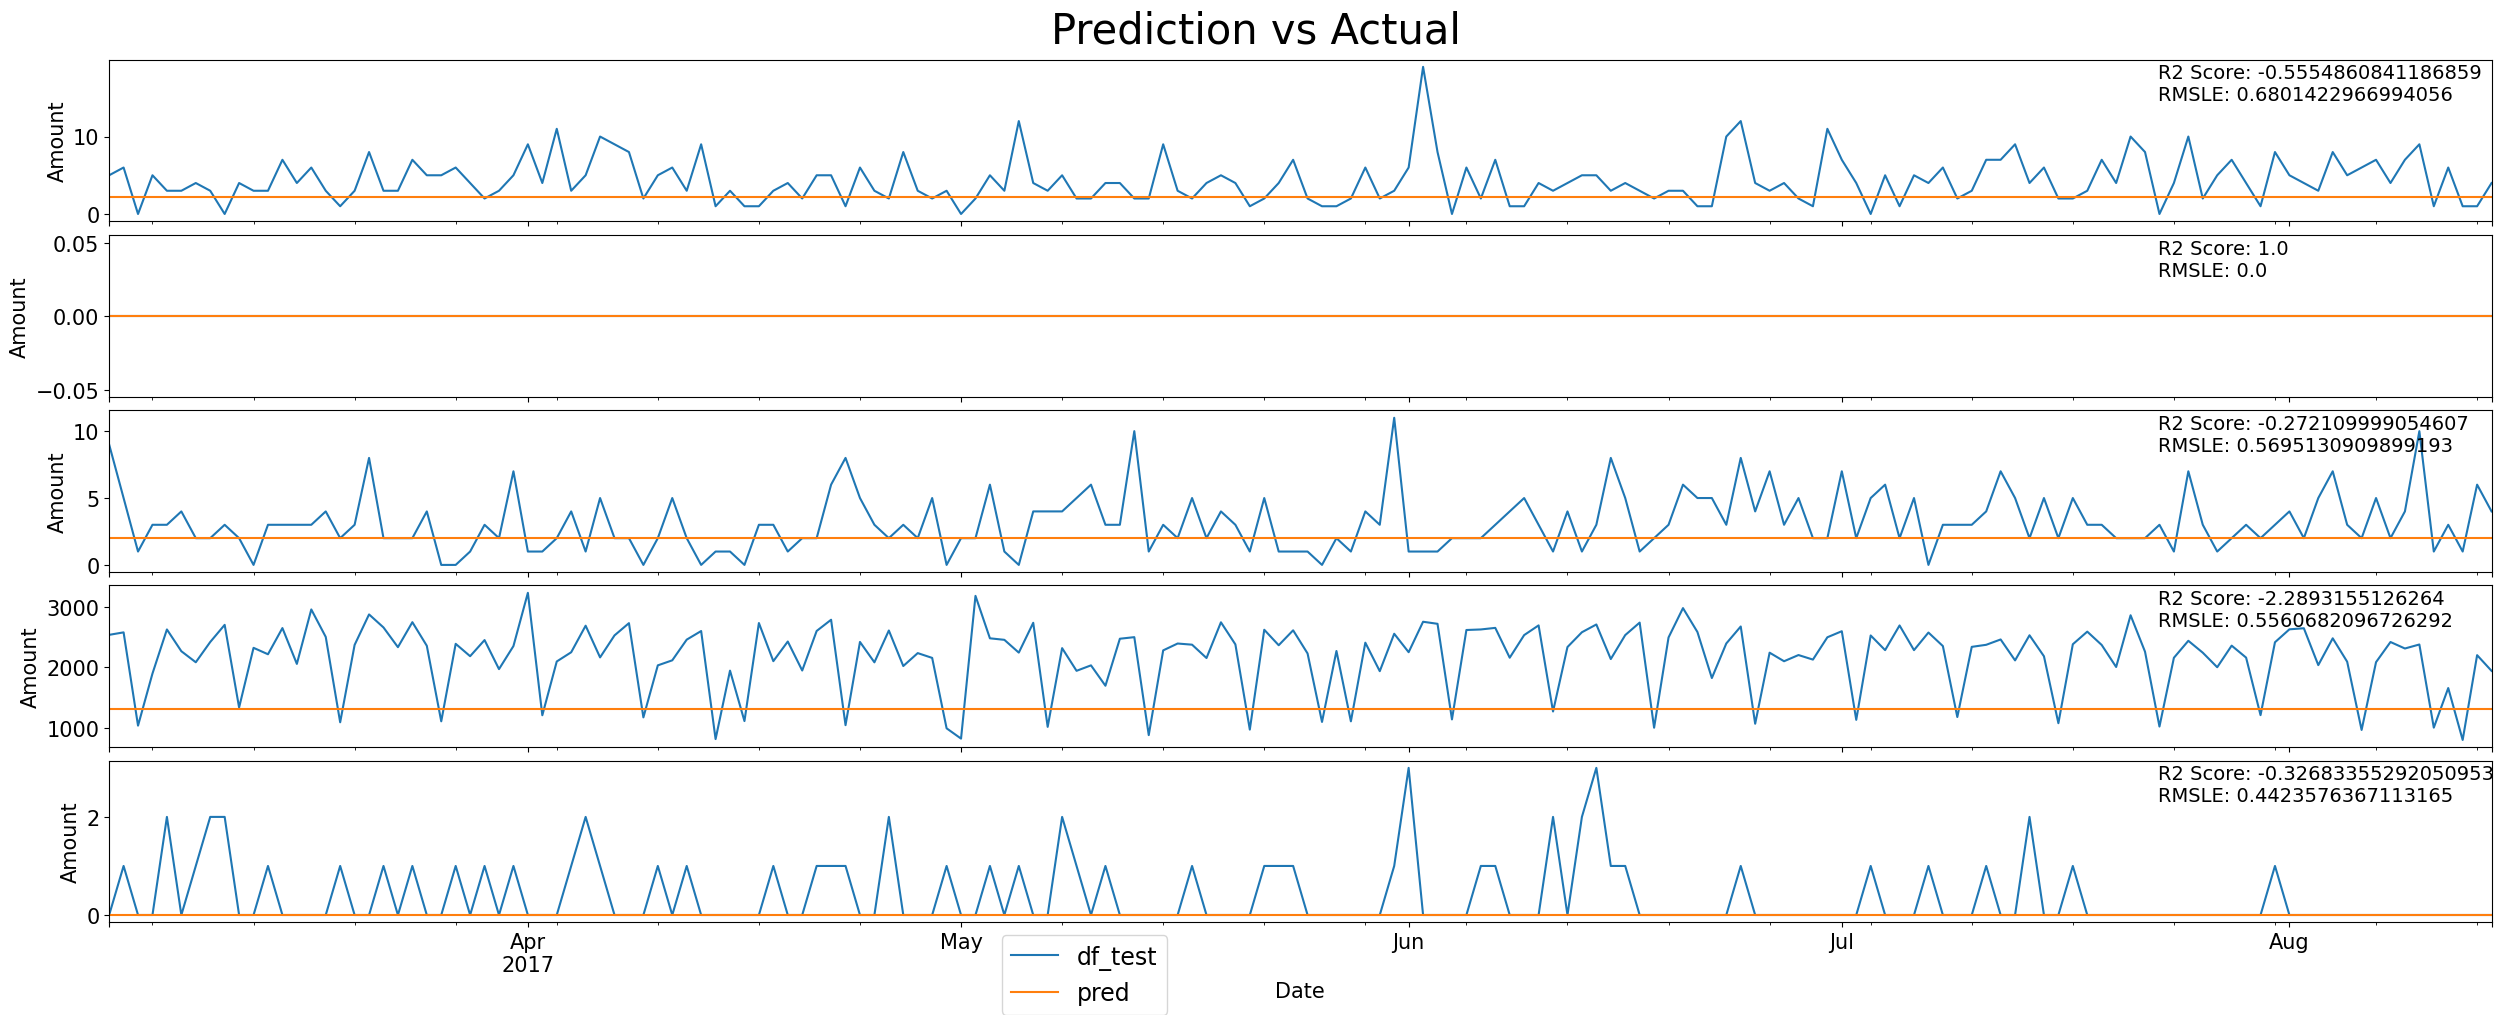

R2 Score                      -2.644307
Root Mean Squared Log Error    1.407111
dtype: float64


In [7]:
experiment(X_train, X_test, y_train, y_test, model2, 'model2', '6 layers of 200 LSTM cells')


## Implementing Layer Normalization

In [8]:
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [9]:
def model3(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(
            100), input_shape=[X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 01m 01s]
val_loss: 11.356813430786133

Best val_loss So Far: 2.558145523071289
Total elapsed time: 00h 27m 11s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 0s 8ms/step


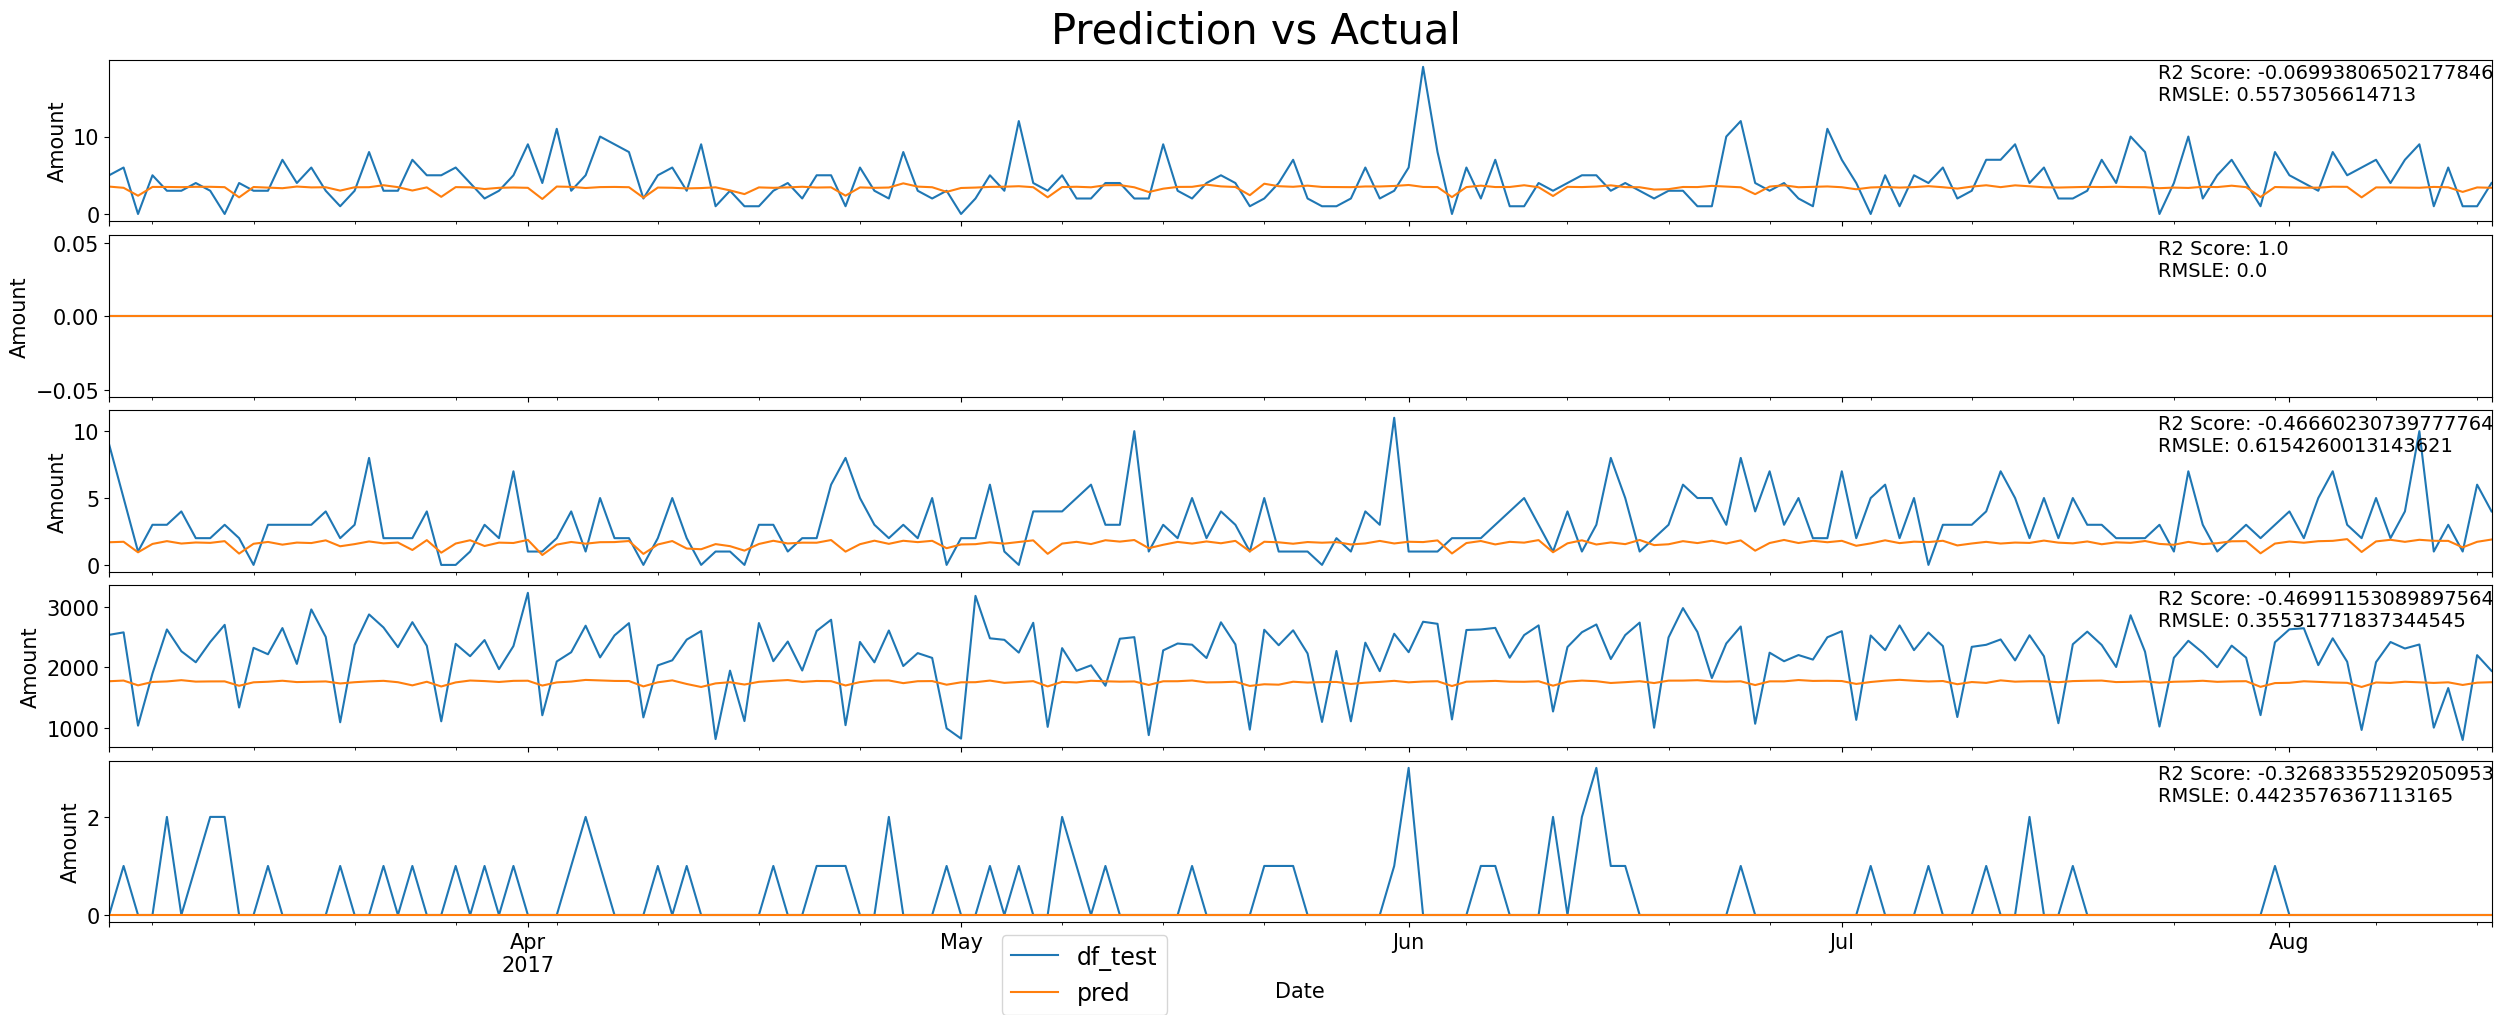

R2 Score                      -0.638444
Root Mean Squared Log Error    0.648923
dtype: float64


In [10]:
experiment(X_train, X_test, y_train, y_test, model3, 'model3', 'single layer of 100 layernormLSTMcells')


## Wide Network

In [11]:
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [12]:
def model4(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1], input_shape=[X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 00m 10s]
val_loss: 7.978337287902832

Best val_loss So Far: 2.8698973655700684
Total elapsed time: 00h 03m 45s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 0s 3ms/step


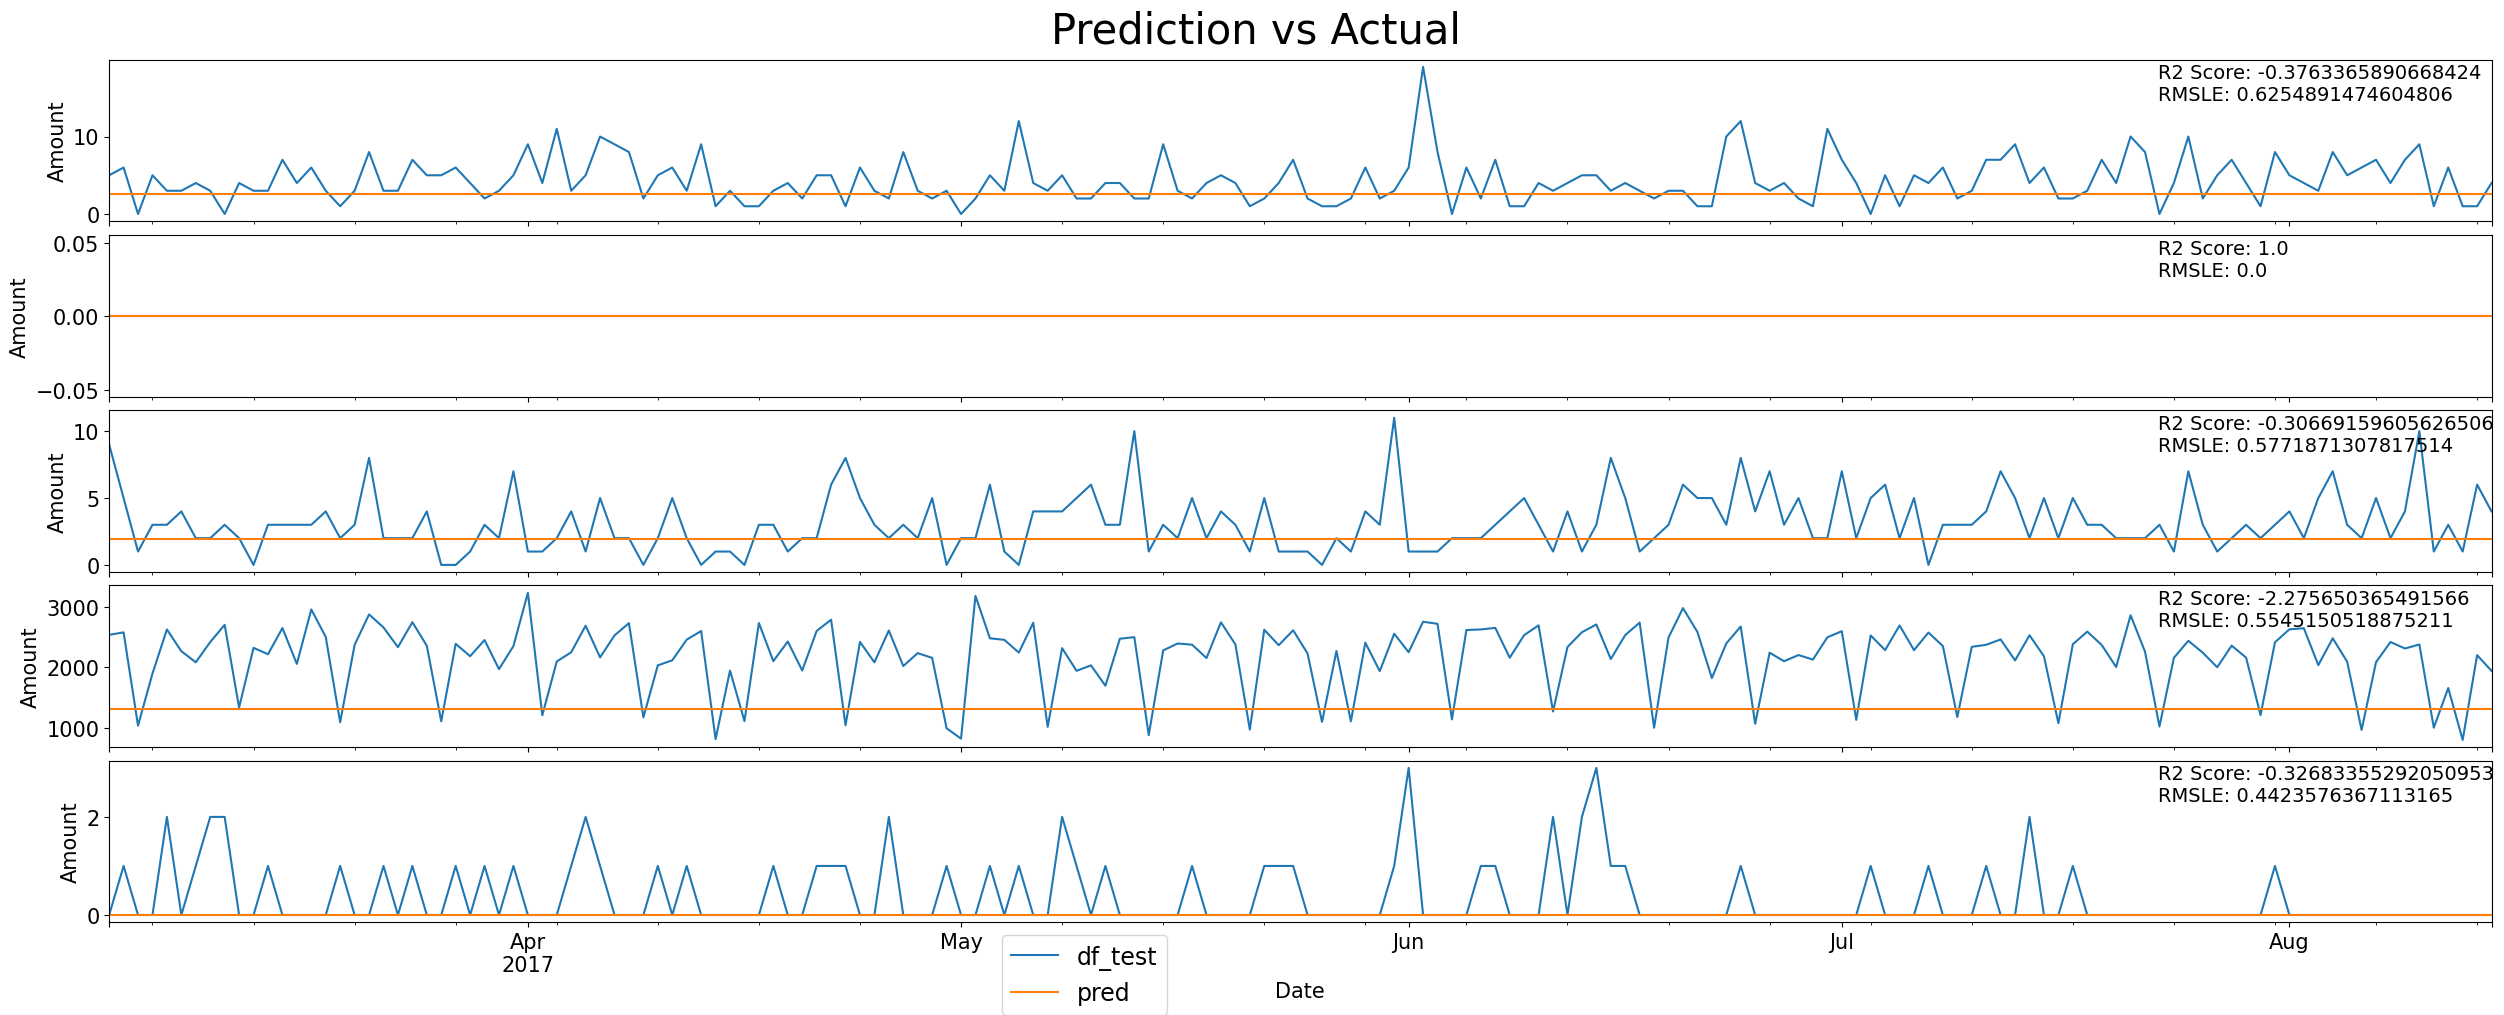

R2 Score                      -2.104970
Root Mean Squared Log Error    1.086726
dtype: float64


In [13]:
experiment(X_train, X_test, y_train, y_test, model4, 'model4', 'Single wide Layer of one cell per series')


## Complex Network with Multiple Inputs

In [14]:
train.var().describe()

count    1.782000e+03
mean     2.899269e+05
std      1.597741e+06
min      0.000000e+00
25%      1.278374e+01
50%      3.950080e+02
75%      1.744068e+04
max      3.103424e+07
dtype: float64

In [15]:
low_var = [train.var().index[i] for i in range(len(train.var())) if train.var()[i]<395]
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [16]:
X1, X2, X3 = [], [], []
low_set = train[low_var]
high_set = train.drop(low_var, axis=1)

for i in range(len(exog)-time_step):
    X1.append(exog.iloc[i:i+time_step, :])
X1 = np.array(X1)

for i in range(len(low_set)-time_step):
    X2.append(low_set.iloc[i:i+time_step, :])
X2 = np.array(X2)

for i in range(len(high_set)-time_step):
    X3.append(high_set.iloc[i:i+time_step, :])
X3 = np.array(X3)

X1_train, X1_test = train_test_split(X1, test_size=0.10, random_state=5, shuffle=False)
X2_train, X2_test = train_test_split(X2, test_size=0.10, random_state=5, shuffle=False)
X3_train, X3_test = train_test_split(X3, test_size=0.10, random_state=5, shuffle=False)
train_sets = [X1_train, X2_train, X3_train]
test_sets = [X1_test, X2_test, X3_test]


In [17]:
def model5(hp):
    input_1 = keras.layers.Input(shape=[train_sets[0].shape[1], train_sets[0].shape[2]])
    input_2 = keras.layers.Input(shape=[train_sets[1].shape[1], train_sets[1].shape[2]])
    input_3 = keras.layers.Input(shape=[train_sets[2].shape[1], train_sets[2].shape[2]])
    exog_hidden_1 = keras.layers.LSTM(10)(input_1)
    low_var_hidden_1 = keras.layers.LSTM(train_sets[1].shape[1]//4)(input_2)
    high_var_hidden_1 = keras.layers.LSTM(train_sets[2].shape[1]//4, return_sequences=True)(input_3)
    high_var_hidden_2 = keras.layers.LSTM(train_sets[2].shape[1]//4, return_sequences=True)(high_var_hidden_1)
    high_var_hidden_3 = keras.layers.LSTM(train_sets[2].shape[1]//4)(high_var_hidden_2)
    concat = keras.layers.concatenate([exog_hidden_1, low_var_hidden_1, high_var_hidden_3])
    output = keras.layers.Dense(y_train.shape[-1], activation='relu')(concat)
    dummy_model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 24 Complete [00h 00m 18s]
val_loss: 3.3961970806121826

Best val_loss So Far: 3.3961970806121826
Total elapsed time: 00h 07m 25s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 1s 3ms/step


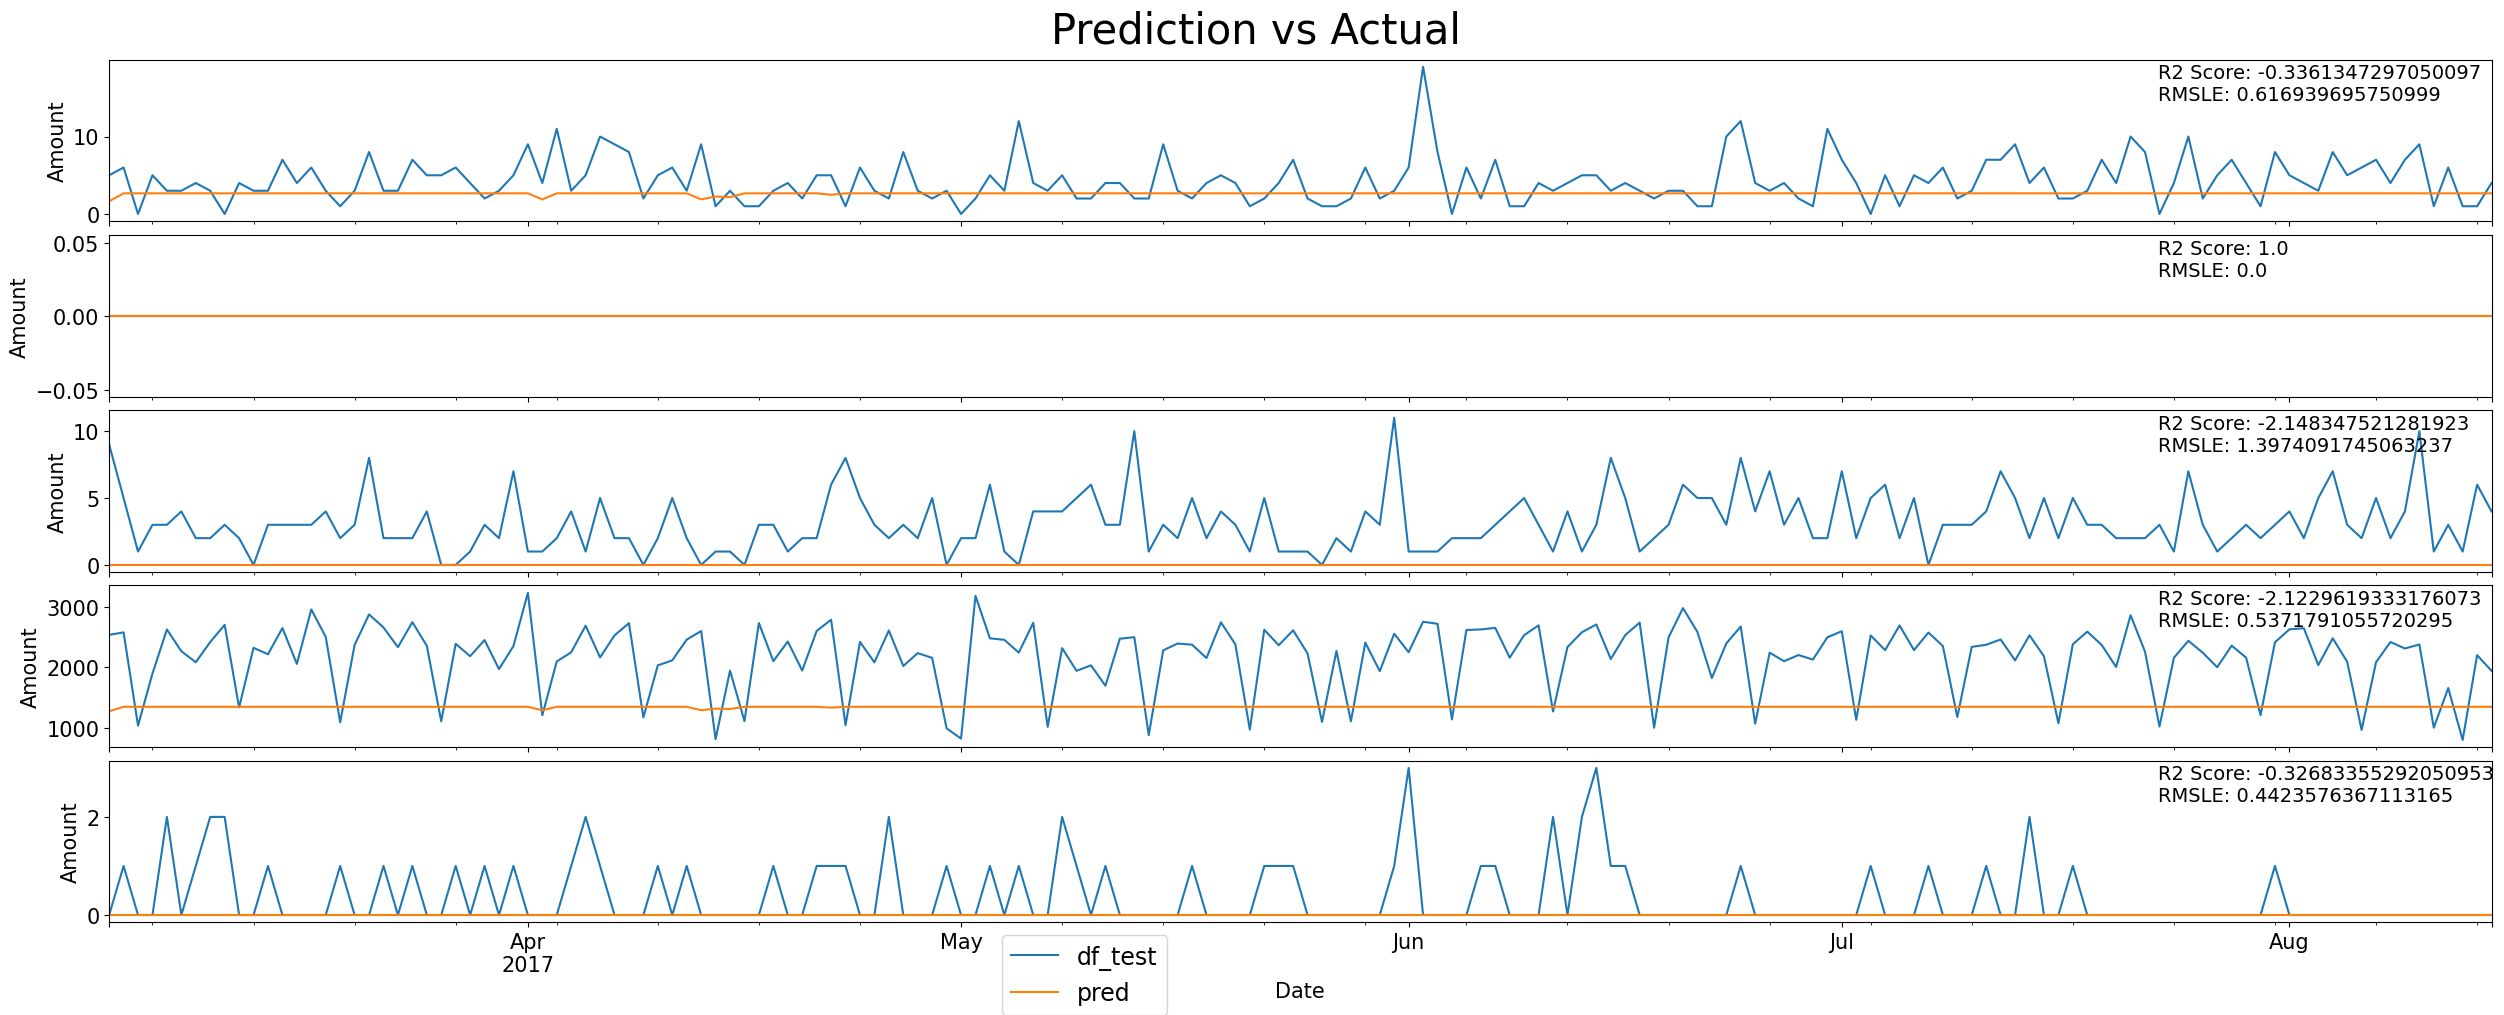

R2 Score                      -1.736274
Root Mean Squared Log Error    0.953693
dtype: float64


In [18]:
experiment(train_sets, test_sets, y_train, y_test, model5, 'model5', 'complex LSTM')

## Double Layer Wide Network

In [19]:
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [20]:
def model6(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1]//2, return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.LSTM(100),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 00m 12s]
val_loss: 10.956095695495605

Best val_loss So Far: 2.435931444168091
Total elapsed time: 00h 05m 08s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 0s 3ms/step


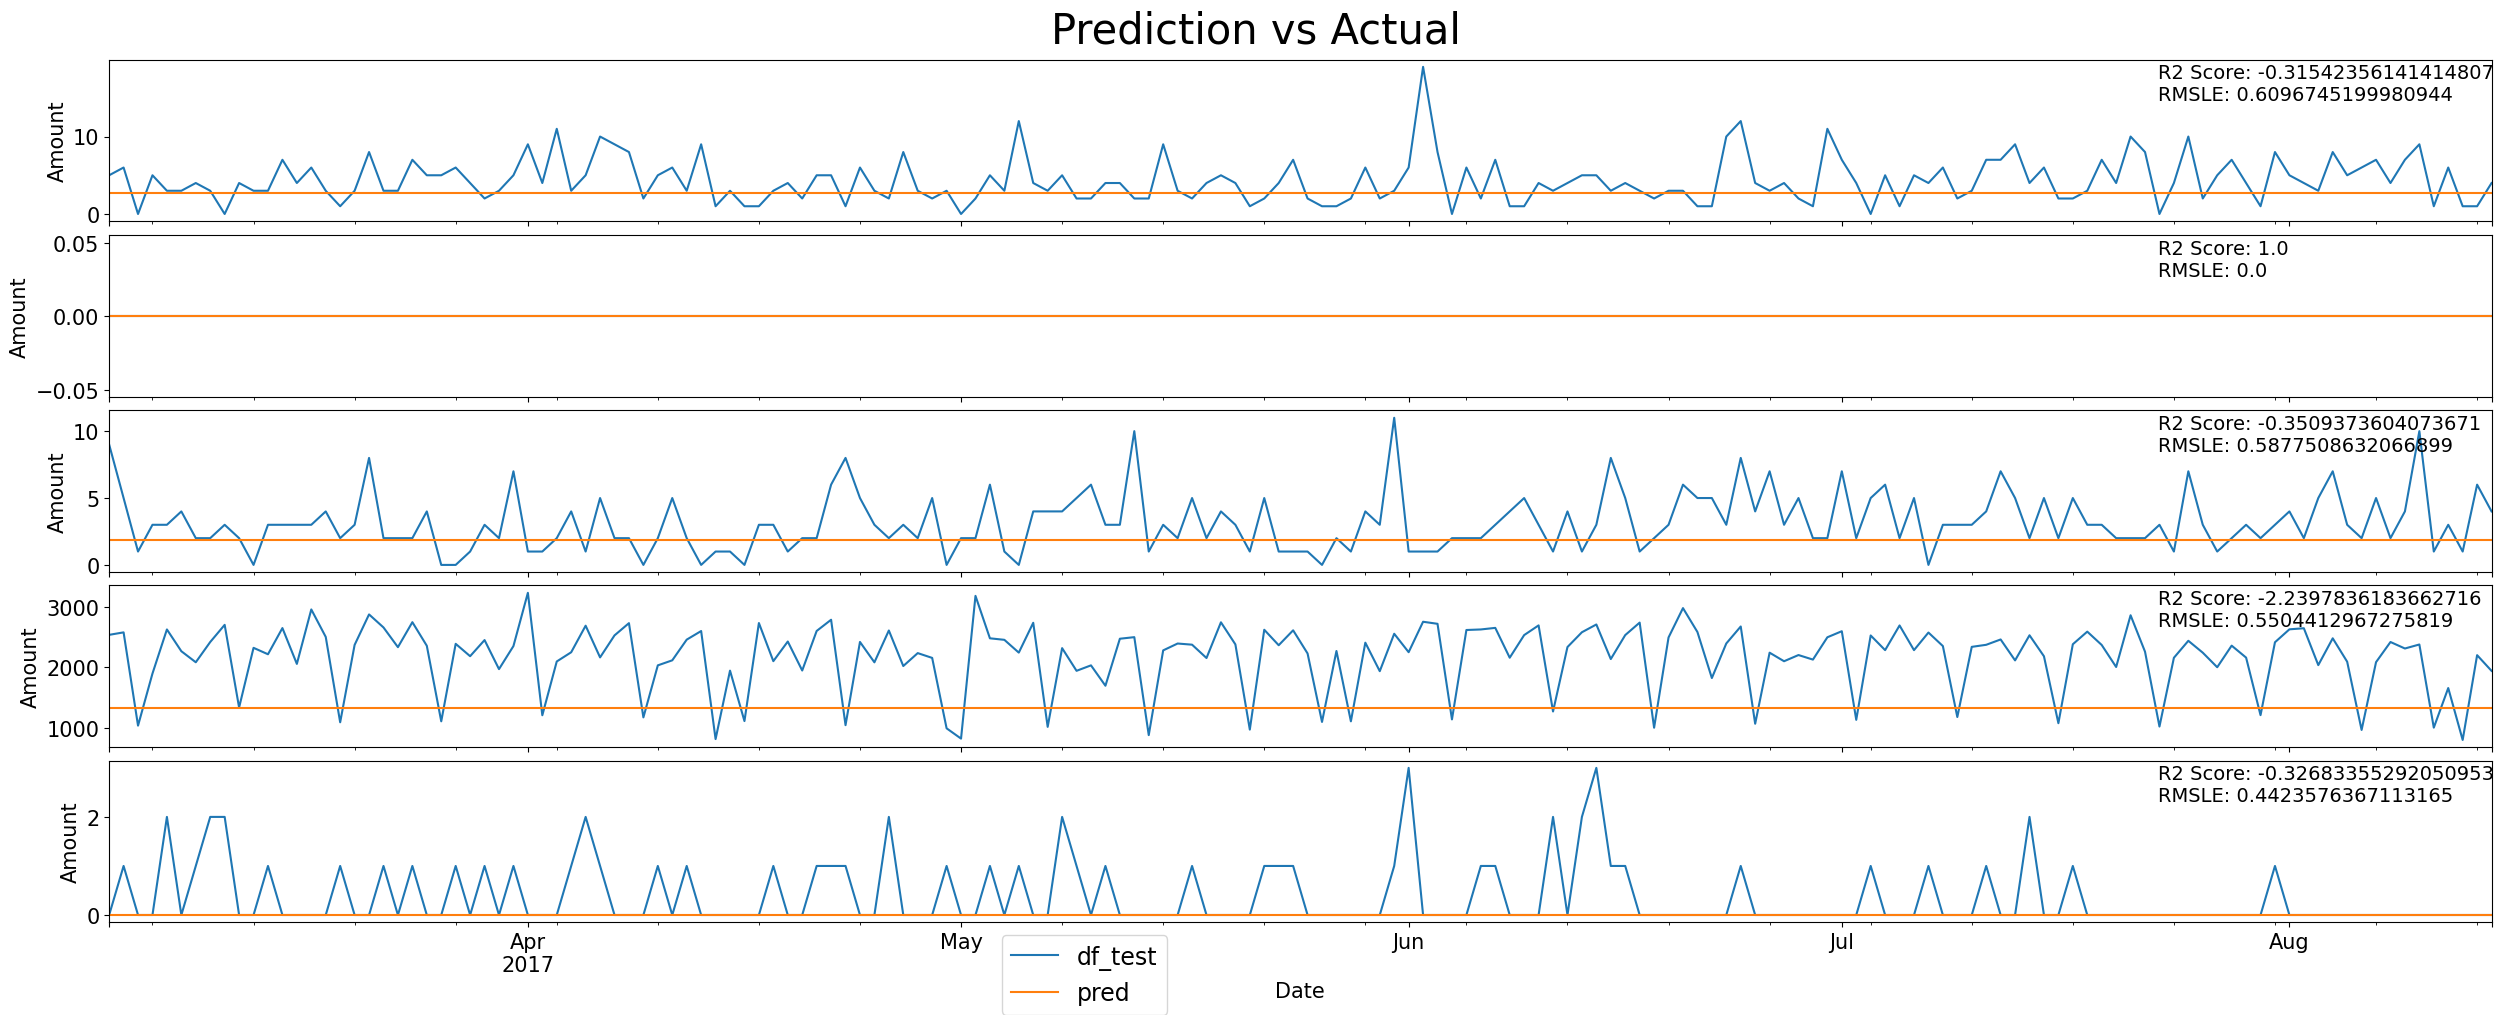

R2 Score                      -2.326561
Root Mean Squared Log Error    1.278545
dtype: float64


In [21]:
experiment(X_train, X_test, y_train, y_test, model6, 'model6', 'Double layer wide network')


## Implementing GRU

In [22]:
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))


(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [23]:
def model7(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.GRU(X_train.shape[1],input_shape=[X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 00m 09s]
val_loss: 10.244035720825195

Best val_loss So Far: 3.167388439178467
Total elapsed time: 00h 03m 53s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 0s 2ms/step


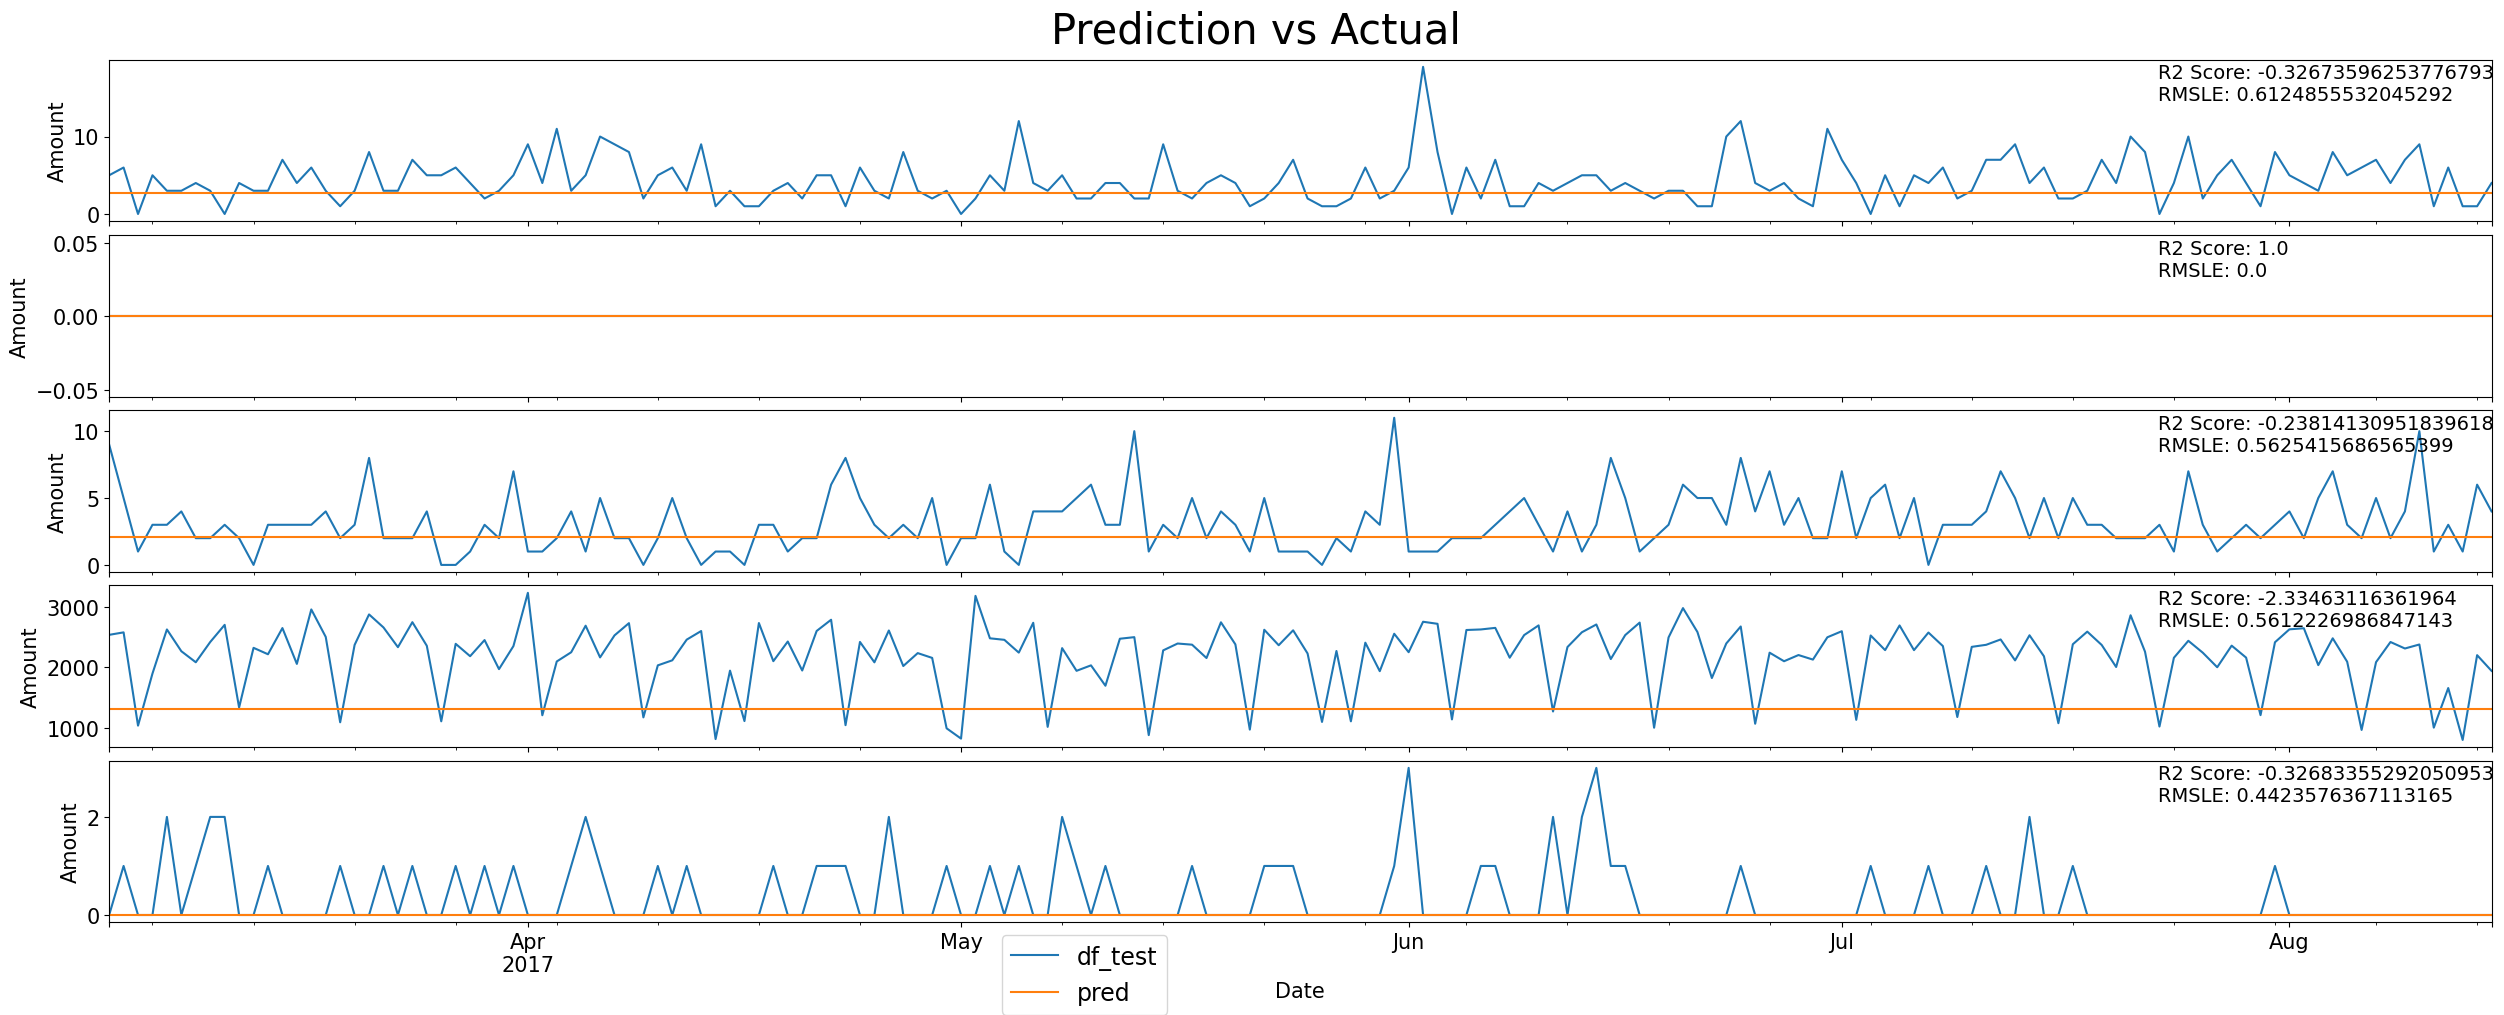

R2 Score                      -2.077706
Root Mean Squared Log Error    1.033990
dtype: float64


In [24]:
experiment(X_train, X_test, y_train, y_test, model7, 'model7', 'Single layer GRU wide network')


## Complex GRU Network with Multiple Inputs

In [25]:
low_var = [train.var().index[i] for i in range(len(train.var())) if train.var()[i]<395]
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [26]:
X1, X2, X3 = [], [], []
low_set = train[low_var]
high_set = train.drop(low_var, axis=1)

for i in range(len(exog)-time_step):
    X1.append(exog.iloc[i:i+time_step, :])
X1 = np.array(X1)

for i in range(len(low_set)-time_step):
    X2.append(low_set.iloc[i:i+time_step, :])
X2 = np.array(X2)

for i in range(len(high_set)-time_step):
    X3.append(high_set.iloc[i:i+time_step, :])
X3 = np.array(X3)

X1_train, X1_test = train_test_split(X1, test_size=0.10, random_state=5, shuffle=False)
X2_train, X2_test = train_test_split(X2, test_size=0.10, random_state=5, shuffle=False)
X3_train, X3_test = train_test_split(X3, test_size=0.10, random_state=5, shuffle=False)
train_sets = [X1_train, X2_train, X3_train]
test_sets = [X1_test, X2_test, X3_test]


In [27]:
def model8(hp):
    input_1 = keras.layers.Input(shape=[train_sets[0].shape[1], train_sets[0].shape[2]])
    input_2 = keras.layers.Input(shape=[train_sets[1].shape[1], train_sets[1].shape[2]])
    input_3 = keras.layers.Input(shape=[train_sets[2].shape[1], train_sets[2].shape[2]])
    exog_hidden_1 = keras.layers.GRU(10)(input_1)
    low_var_hidden_1 = keras.layers.GRU(train_sets[1].shape[1]//4)(input_2)
    high_var_hidden_1 = keras.layers.GRU(train_sets[2].shape[1]//4, return_sequences=True)(input_3)
    high_var_hidden_2 = keras.layers.GRU(train_sets[2].shape[1]//4, return_sequences=True)(high_var_hidden_1)
    high_var_hidden_3 = keras.layers.GRU(train_sets[2].shape[1]//4)(high_var_hidden_2)
    concat = keras.layers.concatenate([exog_hidden_1, low_var_hidden_1, high_var_hidden_3])
    output = keras.layers.Dense(y_train.shape[-1], activation='relu')(concat)
    dummy_model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 24 Complete [00h 00m 17s]
val_loss: 11.334760665893555

Best val_loss So Far: 3.279698133468628
Total elapsed time: 00h 06m 56s
INFO:tensorflow:Oracle triggered exit


6/6 [==============================] - 1s 3ms/step


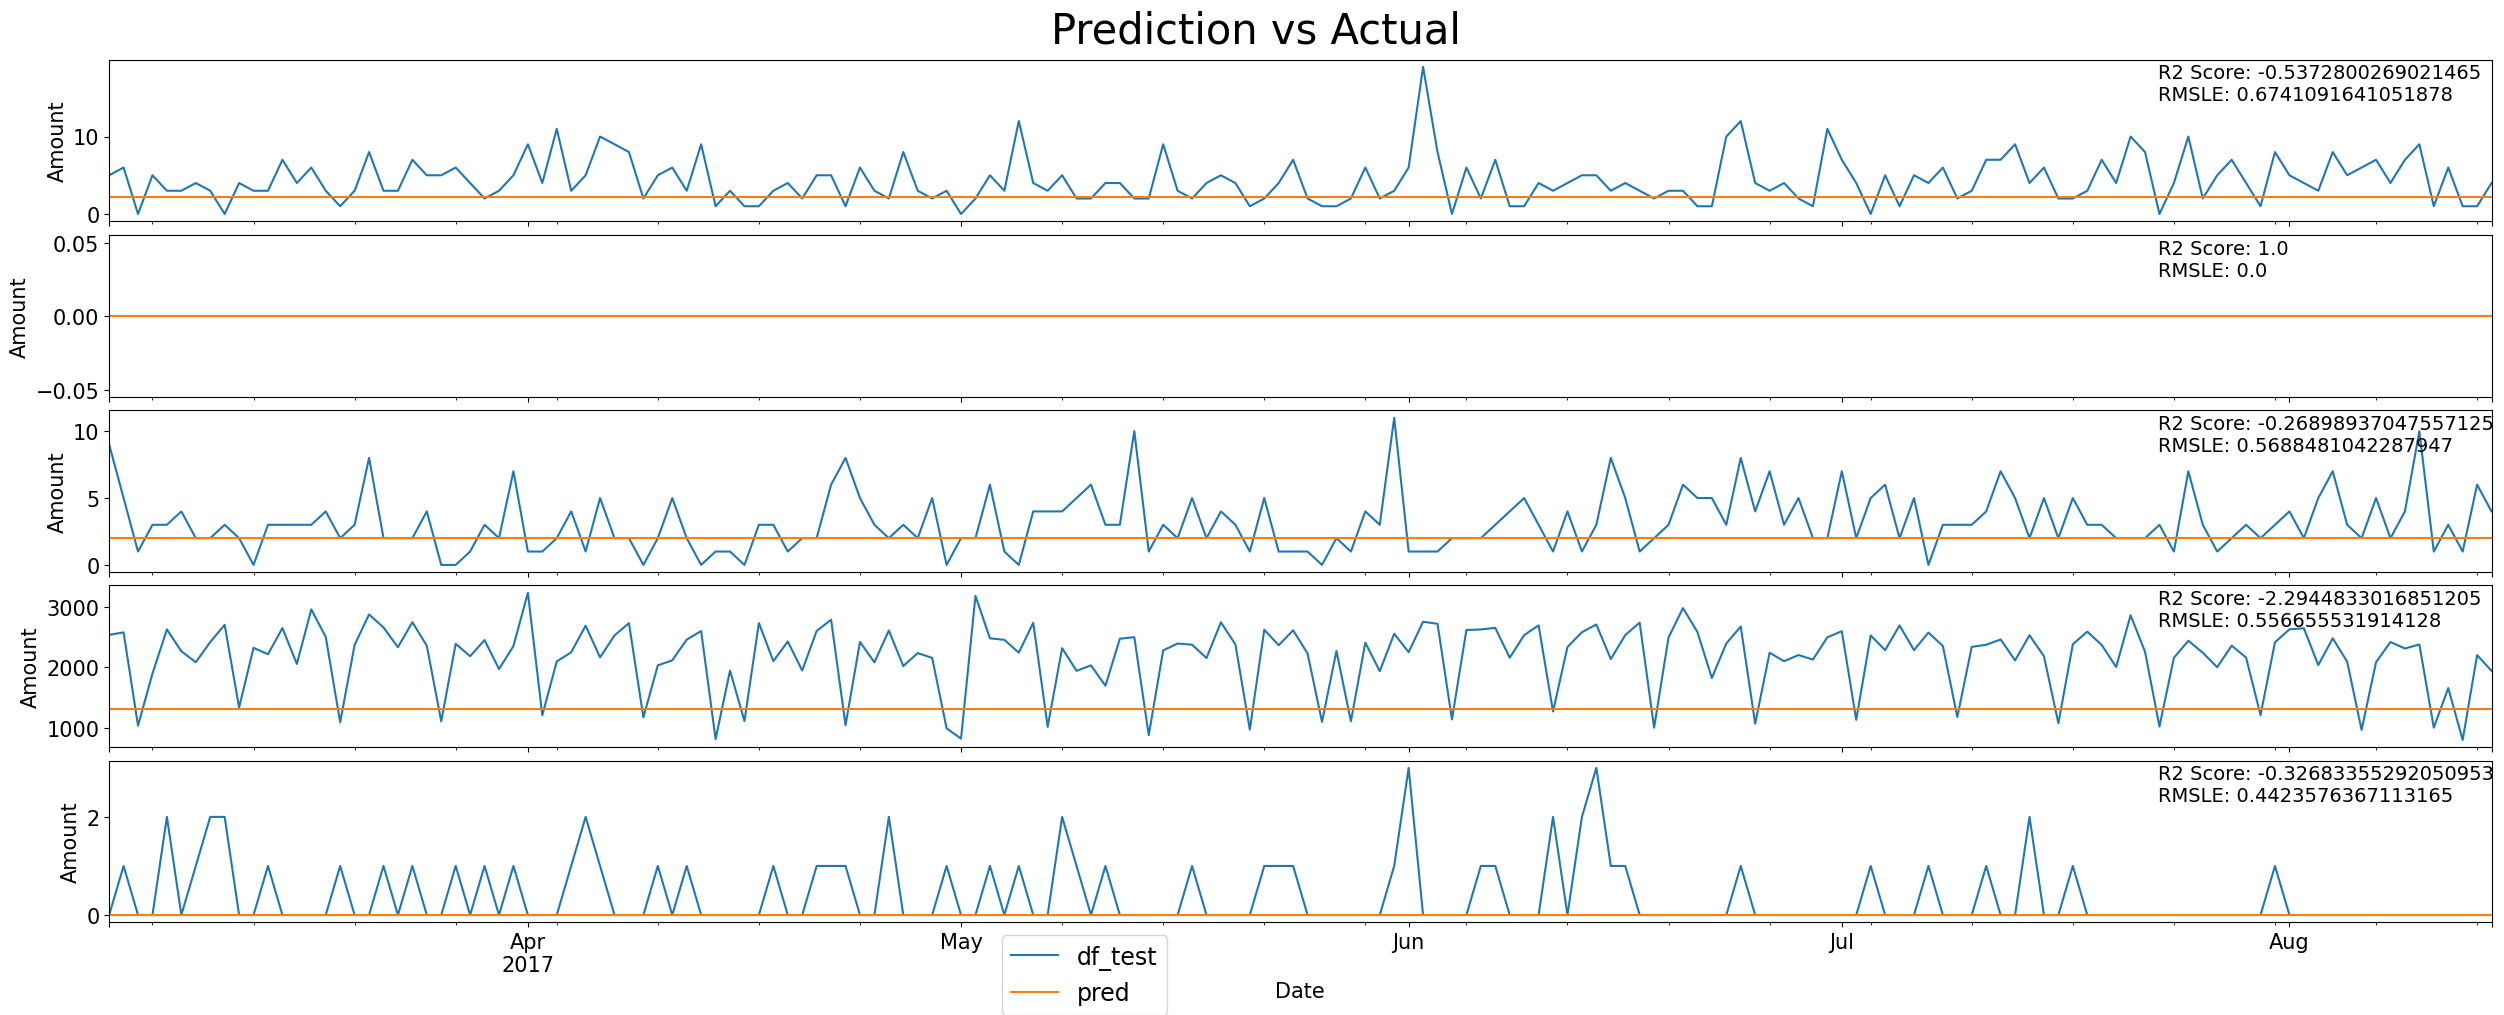

R2 Score                      -2.684846
Root Mean Squared Log Error    1.370515
dtype: float64


In [28]:
experiment(train_sets, test_sets, y_train, y_test, model8, 'model8', 'complex GRU')

## Wide LSTM with Additional Dense Layer

In [29]:
X_train, X_test, y_train, y_test = data_prep(pd.concat([exog, train], axis=1))

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [30]:
def model9(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1],  input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(X_train.shape[1], activation='relu'),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 00m 09s]
val_loss: 11.418485641479492

Best val_loss So Far: 1.0312831401824951
Total elapsed time: 00h 03m 56s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 0s 2ms/step


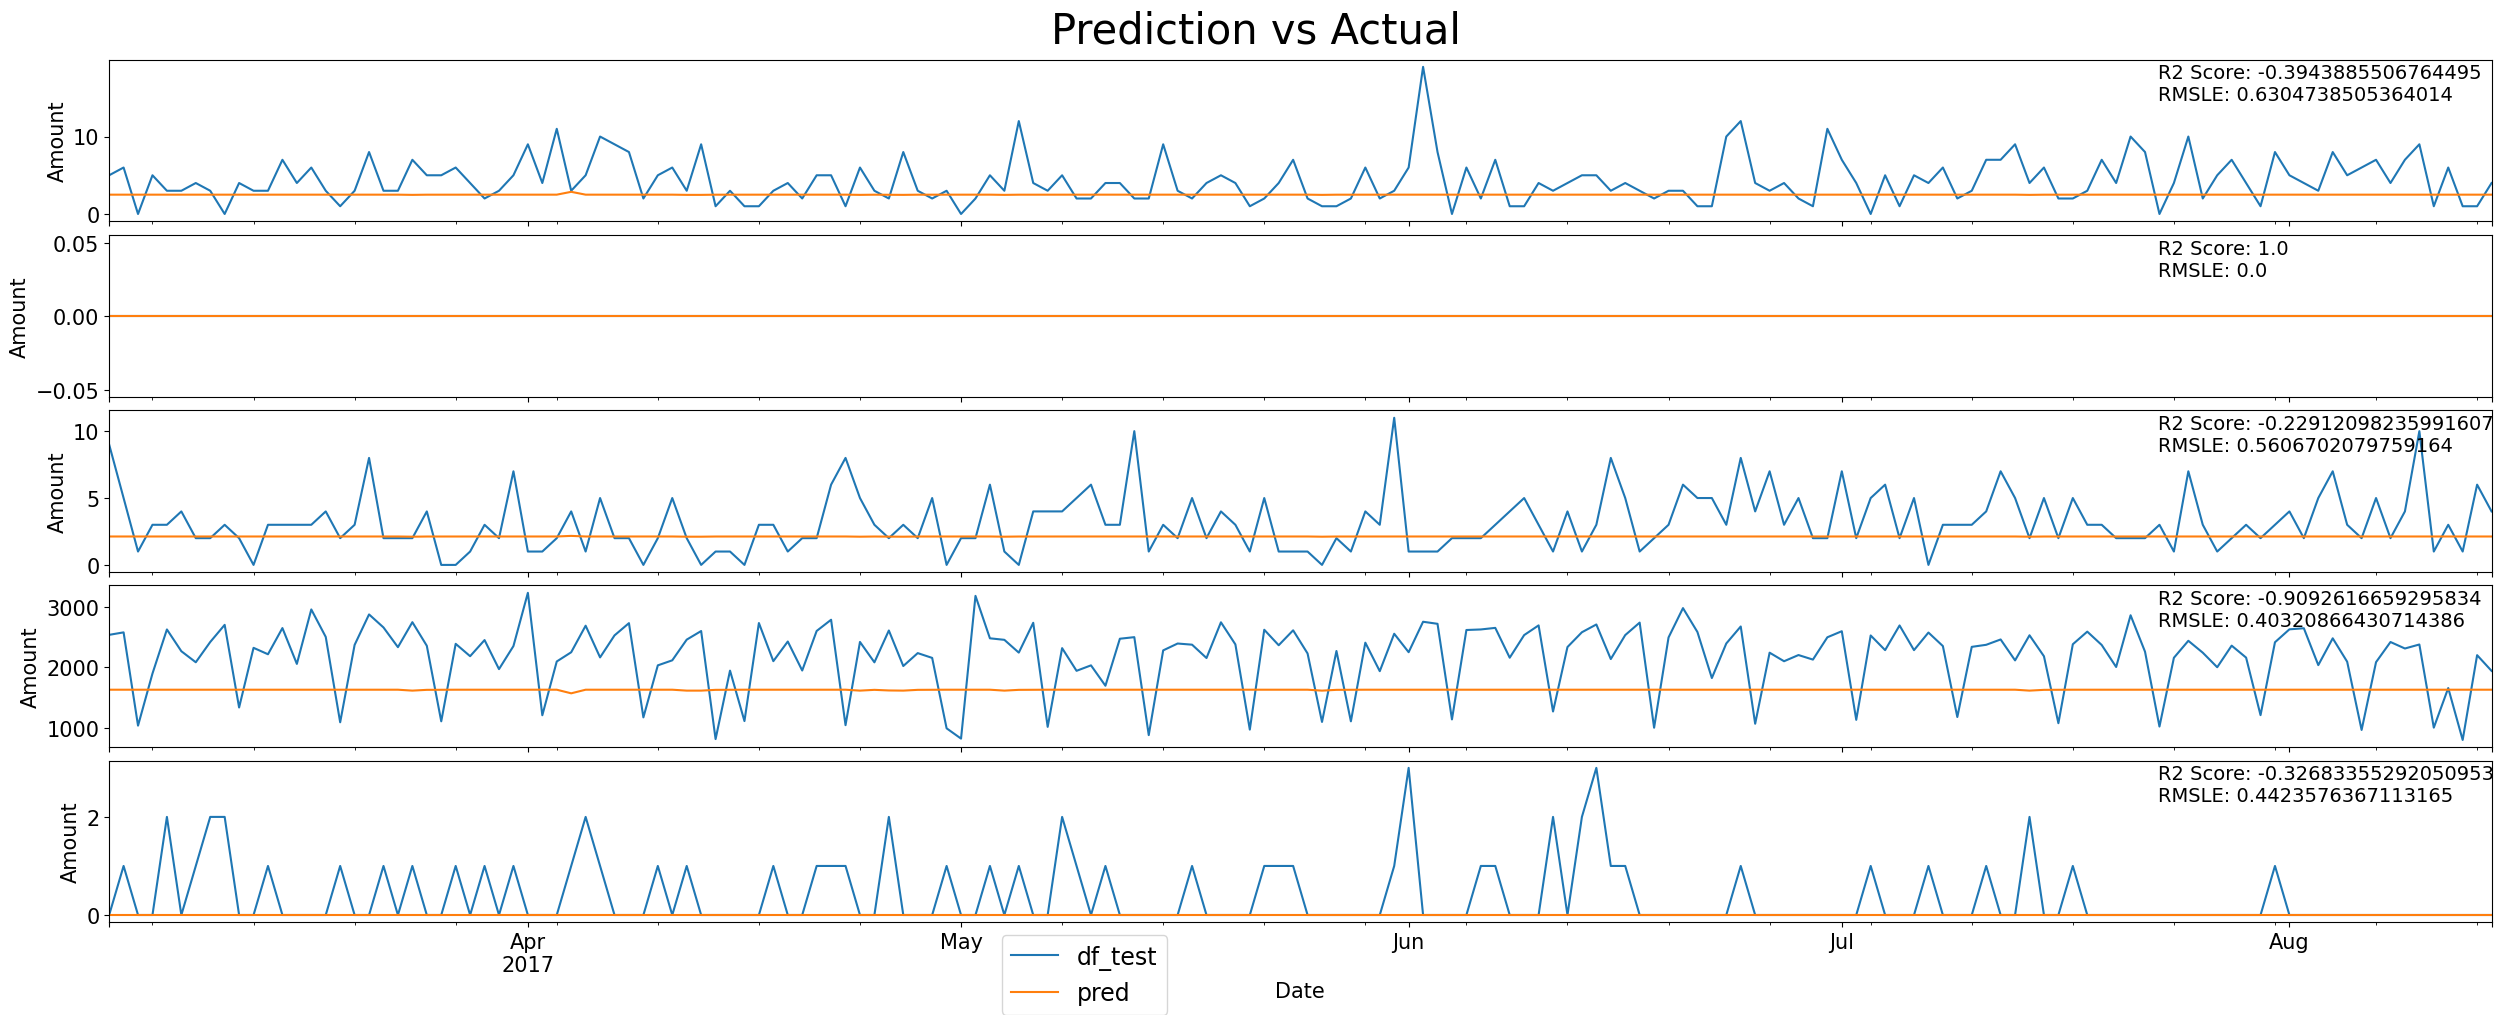

R2 Score                      -1.418371
Root Mean Squared Log Error    0.896471
dtype: float64


In [31]:
experiment(X_train, X_test, y_train, y_test, model9, 'model9', 'Wide LSTM with Additional Dense Layer')


## Normalizing Only Train Data

In [2]:
X_train, X_test, y_train, y_test, scaler_y = data_prep(train, scale=True)

(1488, 30, 1782)
(166, 30, 1782)
(1488, 1782)
(166, 1782)


In [3]:
def model10(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(y_train.shape[-1], input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


In [ ]:
experiment(X_train, X_test, y_train, y_test, model10, 'model10', '100 cell single layer LSTM', scaler_y=scaler_y)


## Normalization with Wide Layer

In [19]:
X_train, X_test, y_train, y_test, scaler_y = data_prep(pd.concat([exog, train], axis=1), scale=True)

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [20]:
def model11(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(500, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 01m 09s]
val_loss: 0.03507741168141365

Best val_loss So Far: 0.03223583102226257
Total elapsed time: 00h 28m 43s
INFO:tensorflow:Oracle triggered exit


6/6 [==============================] - 0s 6ms/step


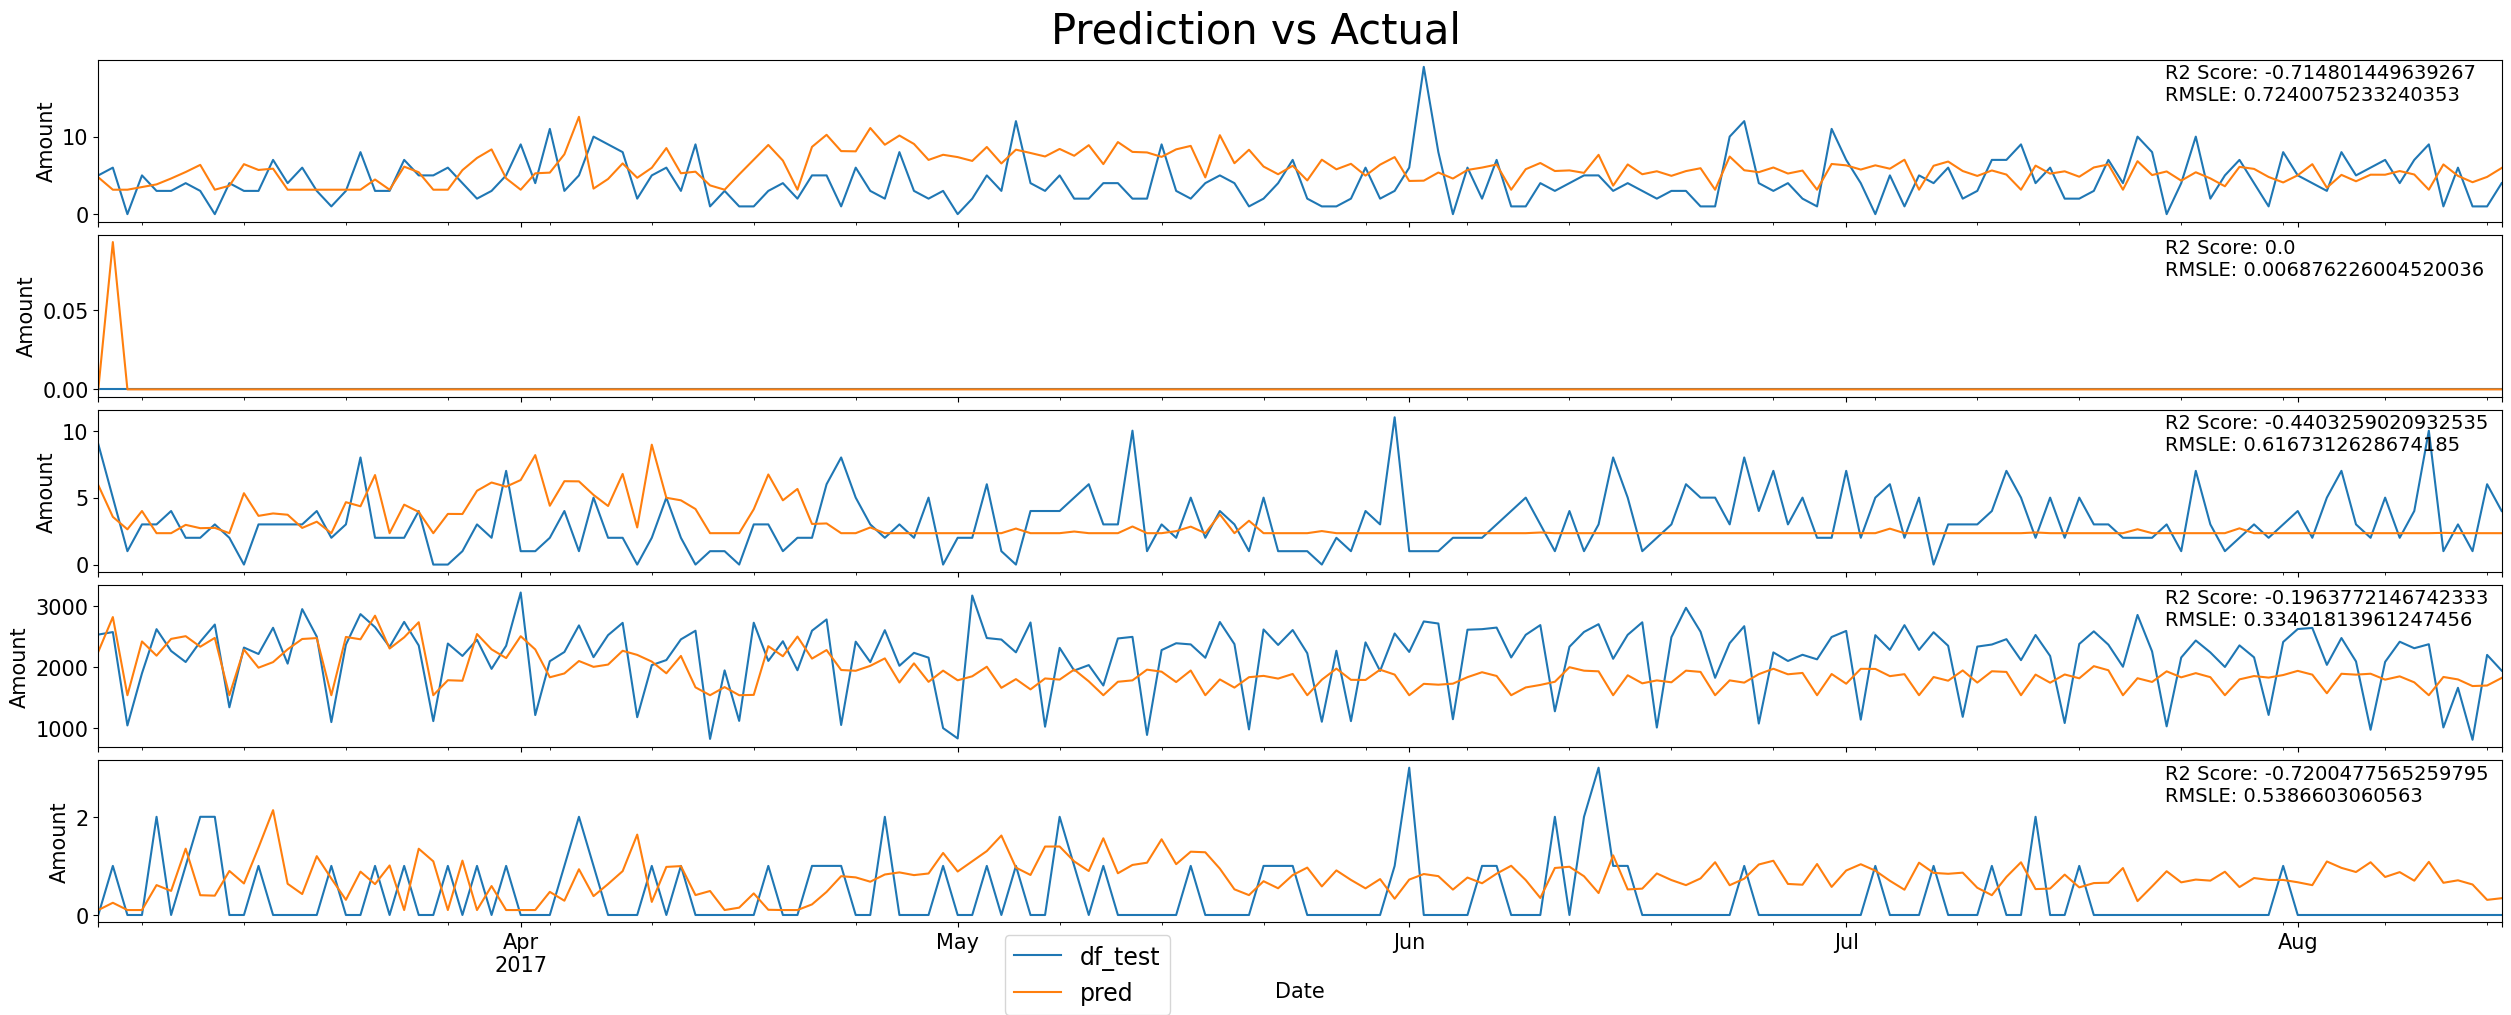

R2 Score                      -0.882560
Root Mean Squared Log Error    0.606579
dtype: float64


In [21]:
experiment(X_train, X_test, y_train, y_test, model11, 'model11', 'Wide single layer LSTM', scaler_y=scaler_y)


## Normalization with Complex Network

In [2]:
low_var = [train.var().index[i] for i in range(len(train.var())) if train.var()[i]<395]
X_train, X_test, y_train, y_test, scaler_y = data_prep(pd.concat([exog, train], axis=1), scale=True)

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [3]:
X1, X2, X3 = [], [], []
low_set = train[low_var]
high_set = train.drop(low_var, axis=1)

for i in range(len(exog)-time_step):
    X1.append(exog.iloc[i:i+time_step, :])
X1 = np.array(X1)

for i in range(len(low_set)-time_step):
    X2.append(low_set.iloc[i:i+time_step, :])
X2 = np.array(X2)

for i in range(len(high_set)-time_step):
    X3.append(high_set.iloc[i:i+time_step, :])
X3 = np.array(X3)

X1_train, X1_test = train_test_split(X1, test_size=0.10, random_state=5, shuffle=False)
X2_train, X2_test = train_test_split(X2, test_size=0.10, random_state=5, shuffle=False)
X3_train, X3_test = train_test_split(X3, test_size=0.10, random_state=5, shuffle=False)
train_sets = [X1_train, X2_train, X3_train]
test_sets = [X1_test, X2_test, X3_test]


In [4]:
def model12(hp):
    input_1 = keras.layers.Input(shape=[train_sets[0].shape[1], train_sets[0].shape[2]])
    input_2 = keras.layers.Input(shape=[train_sets[1].shape[1], train_sets[1].shape[2]])
    input_3 = keras.layers.Input(shape=[train_sets[2].shape[1], train_sets[2].shape[2]])
    exog_hidden_1 = keras.layers.LSTM(26)(input_1)
    low_var_hidden_1 = keras.layers.LSTM(train_sets[1].shape[1]//3)(input_2)
    high_var_hidden_1 = keras.layers.LSTM(train_sets[2].shape[1]//3, return_sequences=True)(input_3)
    high_var_hidden_2 = keras.layers.LSTM(train_sets[2].shape[1]//3, return_sequences=True)(high_var_hidden_1)
    high_var_hidden_3 = keras.layers.LSTM(train_sets[2].shape[1]//3)(high_var_hidden_2)
    concat = keras.layers.concatenate([exog_hidden_1, low_var_hidden_1, high_var_hidden_3])
    output = keras.layers.Dense(y_train.shape[-1], activation='relu')(concat)
    dummy_model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 25 Complete [00h 00m 17s]
val_loss: 0.054201655089855194

Best val_loss So Far: 0.03773091360926628
Total elapsed time: 00h 07m 15s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 1s 3ms/step


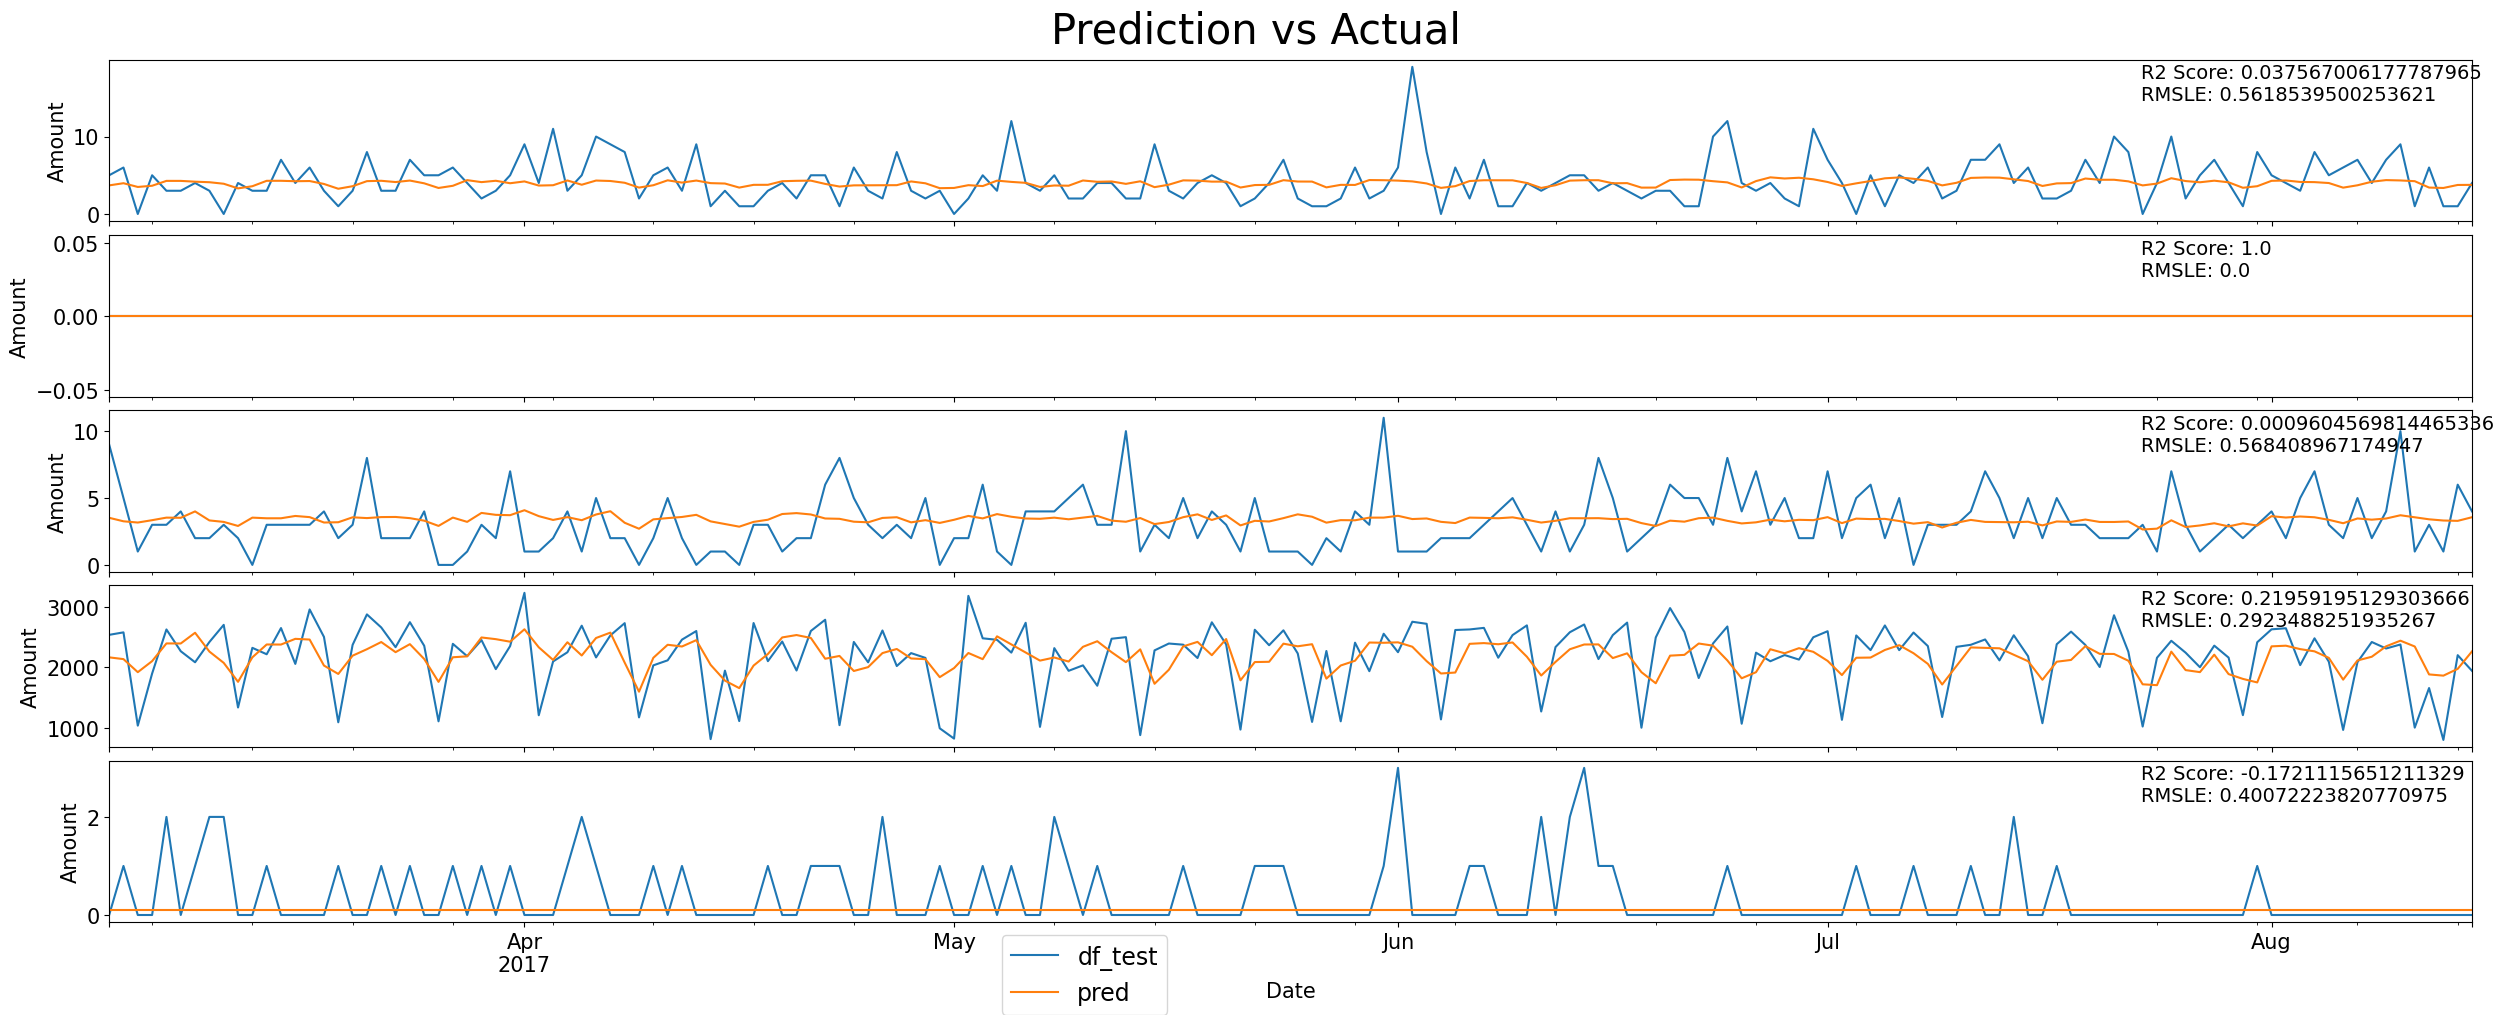

R2 Score                      -0.165047
Root Mean Squared Log Error    0.519058
dtype: float64


In [5]:
experiment(train_sets, test_sets, y_train, y_test, model12, 'model12', 'complex LSTM with normalized data', scaler_y=scaler_y)

## Normalization with GRU

In [6]:
X_train, X_test, y_train, y_test, scaler_y = data_prep(pd.concat([exog, train], axis=1), scale=True)

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [7]:
def model13(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.GRU(X_train.shape[1], input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


Trial 26 Complete [00h 00m 09s]
val_loss: 0.03320350497961044

Best val_loss So Far: 0.032471489161252975
Total elapsed time: 00h 03m 54s
INFO:tensorflow:Oracle triggered exit
6/6 [==============================] - 0s 2ms/step


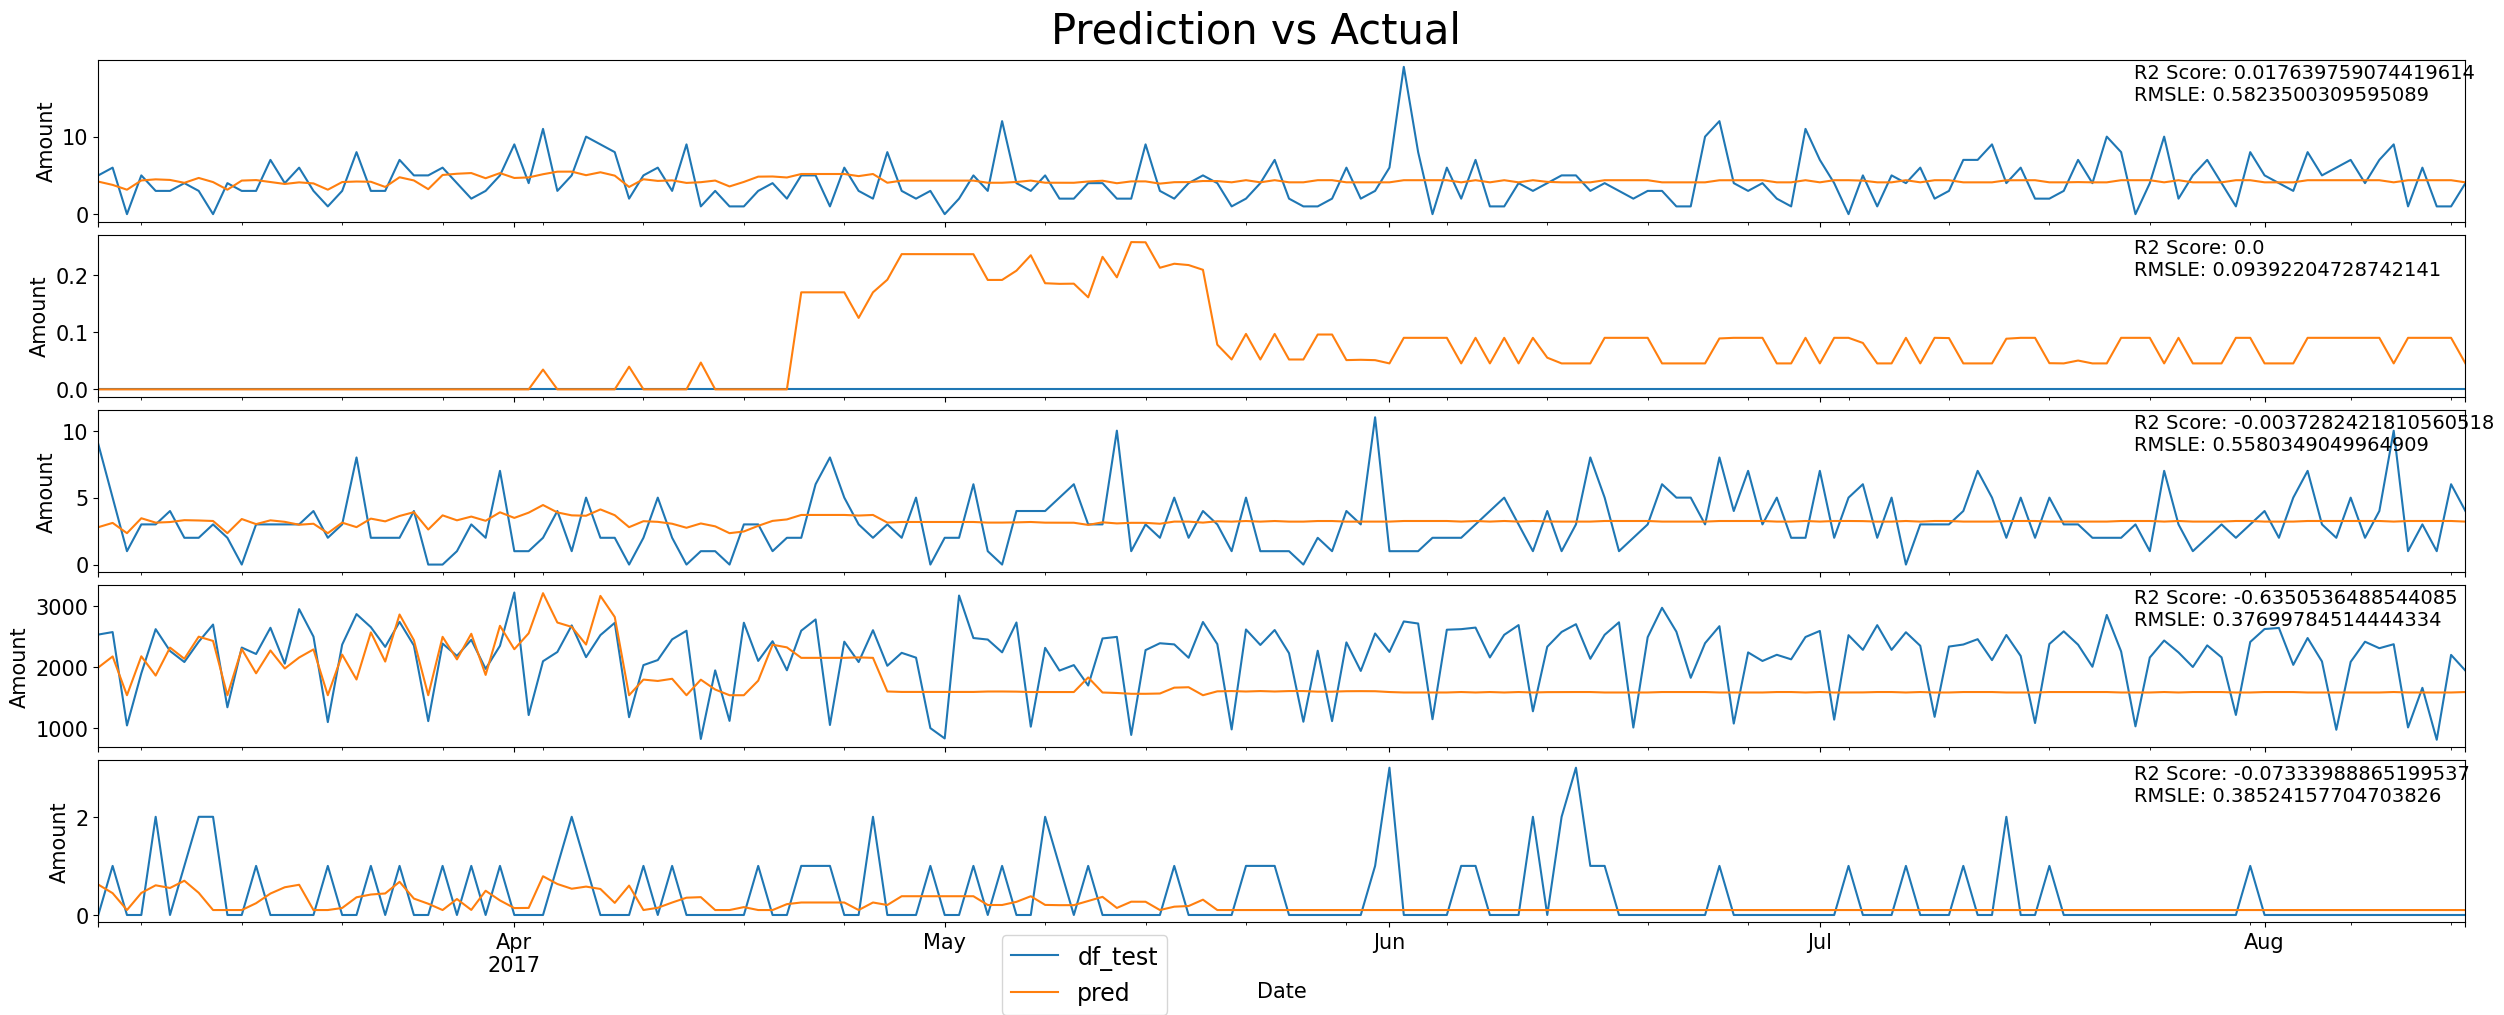

R2 Score                      -4.880214
Root Mean Squared Log Error    0.624888
dtype: float64


In [ ]:
experiment(X_train, X_test, y_train, y_test, model13, 'model13', 'Normalized single layer GRU wide network', scaler_y=scaler_y)


## Normalization of Wide LSTM with Additional Dense Layer

In [8]:
X_train, X_test, y_train, y_test, scaler_y = data_prep(pd.concat([exog, train], axis=1), scale=True)

(1488, 30, 1808)
(166, 30, 1808)
(1488, 1808)
(166, 1808)


In [9]:
def model14(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(y_train.shape[-1], input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(y_train.shape[-1], activation='relu'),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


In [10]:
experiment(X_train, X_test, y_train, y_test, model14, 'model14', 'Normalized Wide LSTM with Additional Dense Layer', scaler_y=scaler_y)


Trial 13 Complete [00h 00m 51s]
val_loss: 0.05405932664871216

Best val_loss So Far: 0.03359527140855789
Total elapsed time: 00h 08m 02s

Search: Running Trial #14

Value             |Best Value So Far |Hyperparameter
0.0025            |0.005             |learning_rate
adam              |adam              |optimizer

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......concatenate
.........vars
......dense
.........vars
............0
............1
......input_layer
.........vars
......input_layer_1
.........vars
......input_layer_2
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_2
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_3
.........cell
............vars
...............0
...............1
...............2

KeyboardInterrupt: 

# Forecast

Best model is model11 with the wide network and data normalized.

In [ ]:
dict = pickle.load(open('/home/nasibul/Desktop/e-commerce/Advanced ARIMA/Data/model11.pkl', 'rb'))
dict['params']

The default settings were already the best ones. 

In [ ]:
X = train
X_train, X_test = train_test_split(X, test_size=0.10, random_state=5, shuffle=False)
y_test_copy = X_test
y_test_index = X_test.index
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
y_train = Y_forecast(X_train)
y_test = Y_forecast(X_test)
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], X.shape[1], 16)
y_test = y_test.values.reshape(y_test.shape[0], X.shape[1], 16)

In [ ]:
final_model = keras.models.Sequential([
        keras.layers.LSTM(X_train.shape[1], return_sequences=True, input_shape=[
                          X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(16, activation='relu')
    ])
final_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())

In [ ]:
pred = predict(final_model, X_train, y_train, X_test, y_test_copy, y_test_index, forecast=True, scaler=scaler)

In [ ]:
submission = submit(pred)
submission.to_csv('3rd_LSTM_submission.csv', header=True, index=False)

## Further Steps

In [ ]:
model11_info = pickle.load(open('/home/nasibul/Desktop/e-commerce/Advanced ARIMA/Data/model11.pkl', 'rb'))

In [ ]:
custom_compare(model11_info['Original test set'], model11_info['Predictions'], [3,4,5])

Adjust hyperparameter space

Brush up on low level tensorflow

Utilize K-means on R2, RMSLE
Cluster recursion ensemble
More importance on analysing this bad data/predictions

Convolutional layers

Incorporate previous clusters from previous notebook

In [ ]:
model11_info['Results'].plot(kind='box')

In [ ]:
model11_info['Results'].plot(kind='box', showfliers=False, grid=True)

In [ ]:
model11_info['Results'][model11_info['Results']['R2 Score'] > -50]\
                            .plot(x='R2 Score',\
                                  y='Root Mean Squared Log Error',\
                                  kind='scatter')


In [ ]:
model11_info['Results'][model11_info['Results']['Root Mean Squared Log Error'] > 1].sort_values(by='Root Mean Squared Log Error', ascending=False)

In [11]:
X_train, X_test, y_train, y_test, scaler_y = data_prep(train, scale=True)

(1488, 30, 1782)
(166, 30, 1782)
(1488, 1782)
(166, 1782)


In [12]:
def model45(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(
            y_train.shape[-1]), input_shape=[X_train.shape[1], X_train.shape[2]]),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


2023-04-30 03:12:37.646890: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.
2023-04-30 03:12:41.044717: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.
2023-04-30 03:12:41.797694: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 762125760 exceeds 10% of free system memory.
2023-04-30 03:12:48.675015: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.
2023-04-30 03:12:49.479220: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3048503040 exceeds 10% of free system memory.


6/6 [==============================] - 0s 27ms/step


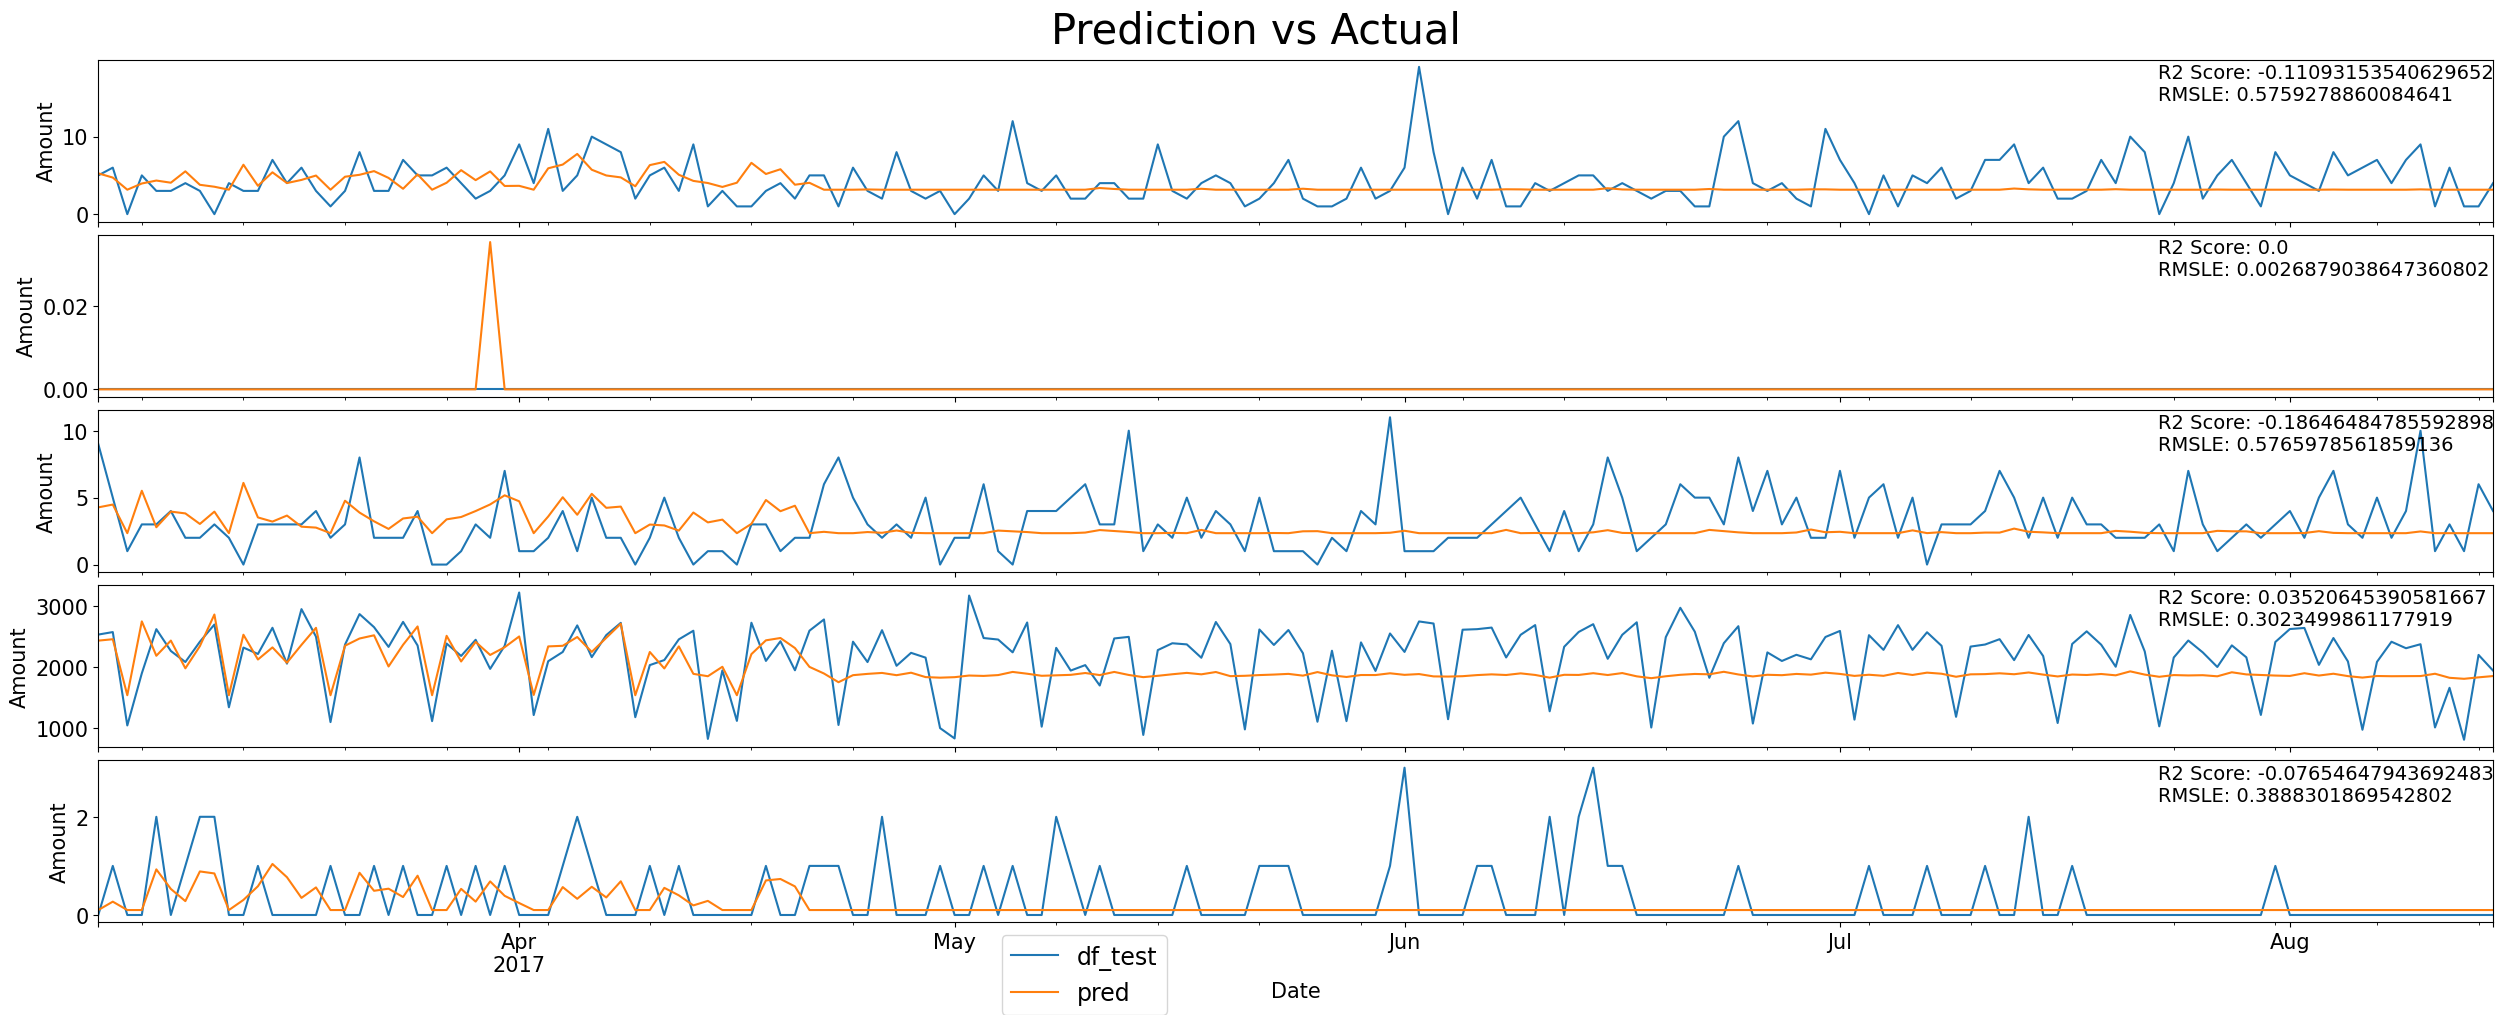

R2 Score                      -0.283128
Root Mean Squared Log Error    0.543932
dtype: float64


In [14]:
experiment(X_train, X_test, y_train, y_test, model45, 'model45', '100 cell single layer LSTM', scaler_y=scaler_y, tune=False)


In [15]:
X_train, X_test, y_train, y_test, scaler_y = data_prep(train.iloc[:, :5], scale=True)

(1488, 30, 5)
(166, 30, 5)
(1488, 5)
(166, 5)


In [19]:
def model45(hp):
    dummy_model = keras.models.Sequential([
        keras.layers.LSTM(256, kernel_initializer='he_uniform',
                          input_shape=[X_train.shape[1], X_train.shape[2]],
                          activation='relu'),
        keras.layers.Dense(y_train.shape[-1], activation='relu')
    ])
    lr = hp.Choice('learning_rate', learning_rates)
    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    opt_dict = {'adam': tf.keras.optimizers.Adam(
        learning_rate=lr), 'sgd': tf.keras.optimizers.SGD(learning_rate=lr)}
    dummy_model.compile(
        loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=opt_dict[optimizer])
    return dummy_model


6/6 [==============================] - 0s 4ms/step


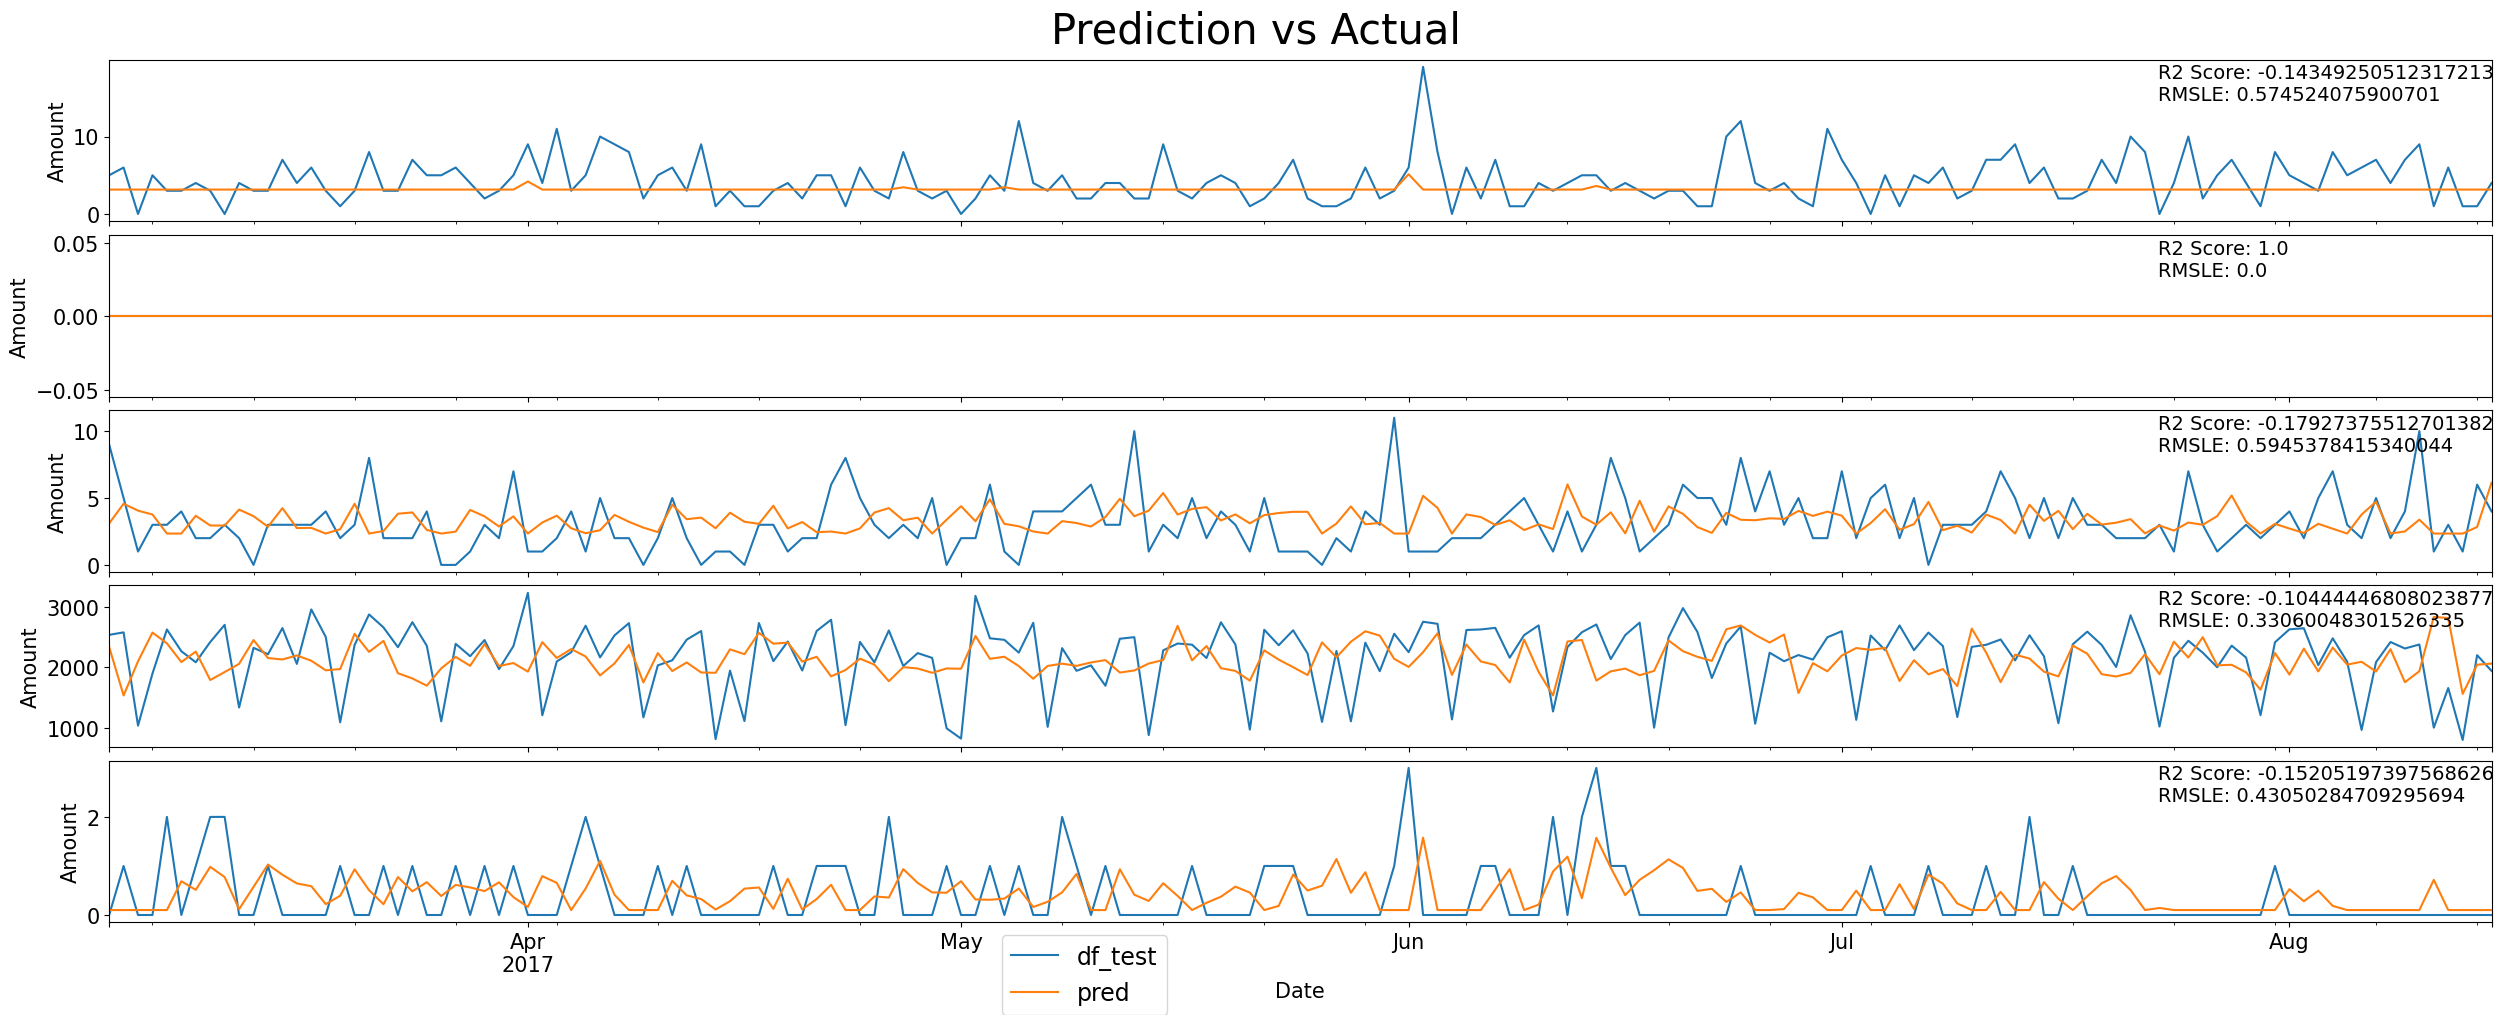

R2 Score                       0.084147
Root Mean Squared Log Error    0.386033
dtype: float64


In [20]:
experiment(X_train, X_test, y_train, y_test, model45, 'model45', '100 cell single layer LSTM', scaler_y=scaler_y, tune=False)
